
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_155660/1883313200.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


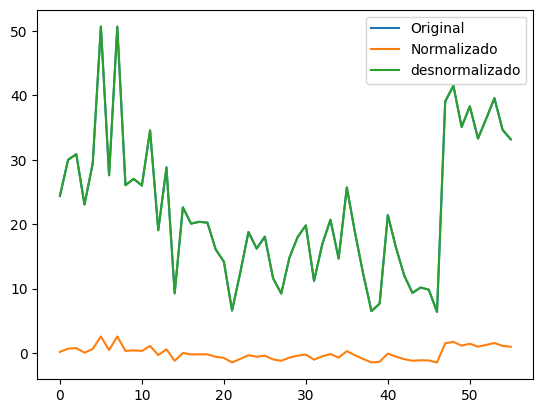

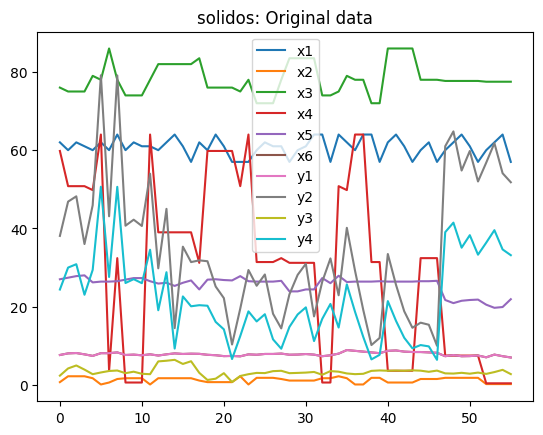

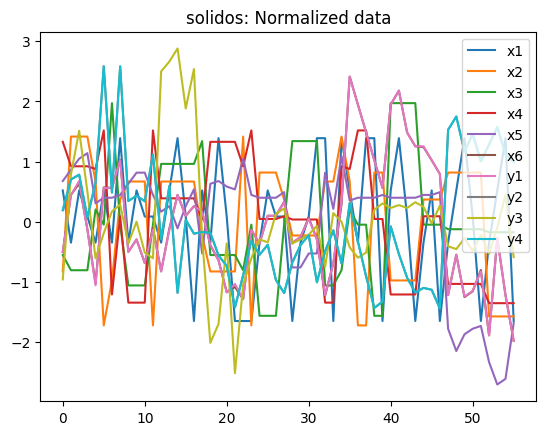

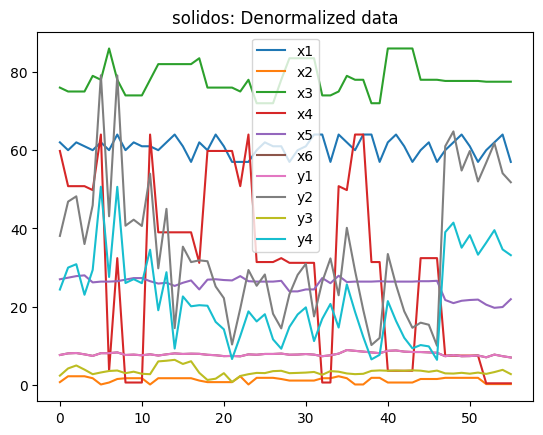

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5, x6  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5'], df['x6']

    input = np.vstack([x1, x2, x3, x4, x5, x6 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y4"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y4")
test_out_scaler()
show_norm(label="solidos")


In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-05-17 23:50:14.581747: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-17 23:50:14.624274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 23:50:14.624316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 23:50:14.625360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-17 23:50:14.630988: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-17 23:50:14.631949: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=6,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[30], [25], [20], [25, 15], [20, 10], [35], [10, 5], [30, 15]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  0.7949717009996675
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.2785640570000396
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.27399007199983316
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.27065589199992246
Stopped at epoch:  6
1/1 [==============================] - 0s 63ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.22491670099952898
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.26126155000019935
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 7 +++++++++

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_2_0,0.809250,0.815291,0.652843,0.708385,23.004516,9.683934,59.311256,33.037970
model_1_2_1,0.825384,0.821806,0.628760,0.692891,21.058735,9.342357,63.425891,34.793432
model_1_2_2,0.837685,0.824858,0.606393,0.677766,19.575233,9.182347,67.247170,36.506969
model_1_2_3,0.846954,0.825142,0.585725,0.663168,18.457413,9.167471,70.778262,38.160788
model_1_2_4,0.853830,0.823294,0.566674,0.649196,17.628124,9.264347,74.033086,39.743753
model_1_2_5,0.858826,0.819871,0.549135,0.635911,17.025630,9.443798,77.029612,41.248887
model_1_2_22,0.859572,0.740669,0.400770,0.511218,16.935622,13.596251,102.377533,55.375668
model_1_2_21,0.860272,0.743424,0.404481,0.514527,16.851191,13.451805,101.743516,55.000843
model_1_2_20,0.861012,0.746435,0.408580,0.518173,16.762026,13.293958,101.043239,54.587740
model_1_2_19,0.861785,0.749716,0.413103,0.522187,16.668721,13.121931,100.270479,54.133010


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Elapsed time:  0.24637425200035068
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Elapsed time:  0.3189981779996742
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Elapsed time:  0.2432662689998324
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Elapsed time:  0.24245322800015856
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Elapsed time:  0.22094734800066362
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Elapsed time:  0.1729520290000437
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_3] | 7 ++++++++++++++++++
Elapsed time:  0.247556610

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_3_9,0.802238,-0.876681,0.937565,0.222821,23.850115,138.139066,7.576272,76.697750
model_1_3_8,0.809358,-0.799496,0.942101,0.255924,22.991516,132.457565,7.025778,73.430857
model_1_3_7,0.816701,-0.717773,0.946909,0.290977,22.105903,126.442093,6.442364,69.971613
model_1_3_6,0.824180,-0.631758,0.951974,0.327872,21.203902,120.110692,5.827774,66.330496
model_1_3_5,0.831669,-0.541930,0.957269,0.366407,20.300774,113.498654,5.185191,62.527599
model_1_3_4,0.838986,-0.449122,0.962754,0.406228,19.418371,106.667182,4.519667,58.597764
model_1_3_3,0.845874,-0.354687,0.968359,0.446762,18.587651,99.715983,3.839528,54.597624
model_1_3_2,0.851973,-0.260712,0.973968,0.487115,17.852073,92.798670,3.158925,50.615260
model_1_3_1,0.856782,-0.170300,0.979377,0.525947,17.272078,86.143595,2.502480,46.783070
model_1_3_0,0.859619,-0.087845,0.984249,0.561325,16.929986,80.074249,1.911289,43.291665


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Elapsed time:  0.3148917939997773
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Elapsed time:  0.1706695100001525
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Elapsed time:  0.3003531980002663
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Elapsed time:  0.29635809200044605
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Elapsed time:  0.22262339699955191
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Elapsed time:  0.2943577500000174
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Elapsed time:  0.2674542780

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_4_0,0.828638,0.980716,0.994762,0.989521,20.666258,1.784251,0.902616,1.369363
model_1_4_1,0.861046,0.984316,0.993621,0.990163,16.757872,1.451134,1.099201,1.285516
model_1_4_2,0.886604,0.984030,0.991780,0.988914,13.675630,1.477589,1.416306,1.448751
model_1_4_3,0.906757,0.981067,0.989598,0.986449,11.245135,1.751801,1.792290,1.770855
model_1_4_4,0.922634,0.976293,0.987290,0.983227,9.330348,2.193510,2.189959,2.191839
model_1_4_5,0.935120,0.970331,0.984985,0.979562,7.824554,2.745160,2.587125,2.670790
model_1_4_6,0.944912,0.963628,0.982758,0.975668,6.643602,3.365284,2.970813,3.179649
model_1_4_7,0.952564,0.956512,0.980652,0.971693,5.720808,4.023769,3.333748,3.699053
model_1_4_8,0.958514,0.949219,0.978687,0.967741,5.003167,4.698500,3.672296,4.215579
model_1_4_9,0.963114,0.941928,0.976872,0.963881,4.448403,5.373157,3.985094,4.719954


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Elapsed time:  0.20355862400083424
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Elapsed time:  0.3175916619993586
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Elapsed time:  0.21425341600024694
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Elapsed time:  0.24429826400046295
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Elapsed time:  0.2921905409993997
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Elapsed time:  0.1989390110002205
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Elapsed time:  0.300108250

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_5_0,0.976999,0.913463,0.984361,0.955127,2.773919,8.954964,1.468986,5.432155
model_1_5_1,0.978306,0.910474,0.983913,0.953611,2.616339,9.264229,1.511030,5.615668
model_1_5_24,0.978800,0.879908,0.958837,0.930623,2.556747,12.427162,3.866369,8.398561
model_1_5_23,0.978890,0.880290,0.959303,0.930966,2.545829,12.387711,3.822545,8.357052
model_1_5_22,0.978989,0.880712,0.959817,0.931345,2.533989,12.344019,3.774295,8.311204
model_1_5_21,0.979095,0.881180,0.960382,0.931763,2.521205,12.295613,3.721266,8.260632
model_1_5_20,0.979209,0.881697,0.961002,0.932223,2.507448,12.242049,3.663041,8.204875
model_1_5_2,0.979246,0.907625,0.983005,0.951991,2.502999,9.559035,1.596272,5.811846
model_1_5_19,0.979331,0.882270,0.961681,0.932731,2.492714,12.182769,3.599219,8.143449
model_1_5_18,0.979461,0.882904,0.962425,0.933289,2.477032,12.117213,3.529390,8.075880


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Elapsed time:  0.35554411399971286
Stopped at epoch:  8
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Elapsed time:  0.2184105019996423
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Elapsed time:  0.2815900079995117
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Elapsed time:  0.28578443599963066
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Elapsed time:  0.22201342700009263
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Elapsed time:  0.17850384600023972
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Elapsed time:  0.23122783

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_6_0,0.985751,0.967794,0.981457,0.972969,1.718412,2.727484,0.974966,1.902770
model_1_6_24,0.986493,0.900515,0.964370,0.924112,1.628987,8.425290,1.873339,5.342021
model_1_6_23,0.986599,0.901461,0.964598,0.924794,1.616116,8.345183,1.861382,5.293980
model_1_6_22,0.986715,0.902505,0.964849,0.925547,1.602131,8.256767,1.848161,5.240951
model_1_6_21,0.986841,0.903656,0.965127,0.926378,1.586983,8.159237,1.833573,5.182456
model_1_6_1,0.986976,0.963448,0.980256,0.969780,1.570688,3.095506,1.038093,2.127311
model_1_6_20,0.986977,0.904925,0.965433,0.927294,1.570634,8.051764,1.817486,5.117985
model_1_6_19,0.987122,0.906323,0.965770,0.928303,1.553060,7.933437,1.799748,5.046995
model_1_6_18,0.987278,0.907859,0.966141,0.929412,1.534266,7.803310,1.780224,4.968914
model_1_6_17,0.987444,0.909546,0.966550,0.930630,1.514293,7.660411,1.758740,4.883155


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Elapsed time:  0.23437299400029588
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Elapsed time:  0.24866362400007347
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Elapsed time:  0.20874366400039435
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Elapsed time:  0.21576679500049067
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Elapsed time:  0.29199078700003156
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Elapsed time:  0.35964855600013834
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Elapsed time:  0.269533

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_7_24,0.981131,0.972277,0.860782,0.931273,2.275583,3.293514,12.194821,7.482361
model_1_7_23,0.981330,0.972488,0.862451,0.932028,2.251630,3.268346,12.048639,7.400246
model_1_7_22,0.981547,0.972722,0.864285,0.932857,2.225411,3.240545,11.887938,7.309913
model_1_7_21,0.981785,0.972981,0.866300,0.933769,2.196757,3.209867,11.711490,7.210631
model_1_7_20,0.982044,0.973266,0.868508,0.934770,2.165517,3.176034,11.518042,7.101683
model_1_7_19,0.982326,0.973579,0.870926,0.935866,2.131542,3.138777,11.306270,6.982310
model_1_7_18,0.982631,0.973925,0.873567,0.937066,2.094693,3.097748,11.074945,6.851718
model_1_7_17,0.982961,0.974304,0.876446,0.938375,2.054873,3.052669,10.822745,6.709179
model_1_7_16,0.983317,0.974720,0.879577,0.939801,2.012000,3.003187,10.548490,6.553916
model_1_7_15,0.983698,0.975177,0.882972,0.941350,1.966061,2.948966,10.251094,6.385258


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Elapsed time:  0.23749704200054111
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Elapsed time:  0.18232451299991226
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Elapsed time:  0.25932439699954557
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Elapsed time:  0.25771442399945954
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Elapsed time:  0.19433295999988331
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Elapsed time:  0.21190267000019958
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Elapsed time:  0.259925

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_8_0,0.983574,0.990597,0.985871,0.988130,1.981029,0.792667,2.707764,1.693889
model_1_8_1,0.985429,0.989238,0.984557,0.986874,1.757214,0.907252,2.959729,1.873123
model_1_8_2,0.986821,0.987715,0.983205,0.985544,1.589357,1.035568,3.218834,2.062988
model_1_8_3,0.987848,0.986099,0.981851,0.984183,1.465575,1.171856,3.478207,2.257198
model_1_8_24,0.988263,0.964263,0.966327,0.967543,1.415459,3.012574,6.453494,4.631830
model_1_8_23,0.988352,0.964671,0.966595,0.967840,1.404784,2.978137,6.402141,4.589432
model_1_8_22,0.988447,0.965121,0.966891,0.968167,1.393298,2.940190,6.345445,4.542664
model_1_8_21,0.988549,0.965617,0.967217,0.968529,1.380989,2.898408,6.282857,4.491090
model_1_8_4,0.988588,0.984440,0.980523,0.982824,1.376331,1.311643,3.732851,2.451035
model_1_8_20,0.988658,0.966162,0.967577,0.968927,1.367883,2.852469,6.213864,4.434300


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Elapsed time:  0.24285534199952963
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Elapsed time:  0.2065369740003007
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Elapsed time:  0.26884500199957984
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Elapsed time:  0.19815633300004265
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Elapsed time:  0.19118602300022758
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Elapsed time:  0.2030639570002677
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Elapsed time:  0.21670715

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_9_0,0.990355,0.999634,0.998294,0.998800,1.163226,0.027980,0.241937,0.128665
model_1_9_1,0.991972,0.998814,0.997874,0.998229,0.968172,0.090649,0.301520,0.189883
model_1_9_2,0.993217,0.997684,0.997426,0.997524,0.818063,0.177027,0.364967,0.265469
model_1_9_3,0.994169,0.996374,0.996969,0.996745,0.703247,0.277152,0.429836,0.349003
model_1_9_4,0.994891,0.994978,0.996512,0.995934,0.616126,0.383887,0.494648,0.436009
model_1_9_5,0.995434,0.993560,0.996062,0.995118,0.550711,0.492267,0.558496,0.523435
model_1_9_6,0.995835,0.992164,0.995622,0.994318,0.502283,0.598943,0.620822,0.609240
model_1_9_7,0.996127,0.990820,0.995196,0.993545,0.467121,0.701739,0.681264,0.692107
model_1_9_24,0.996195,0.978634,0.990659,0.986123,0.458852,1.633197,1.324617,1.487984
model_1_9_23,0.996235,0.978938,0.990795,0.986322,0.454047,1.609977,1.305376,1.466635


DataFrame salvo em ../results/metrics_1_9
Testando combinação 2: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Elapsed time:  0.44310058700011723
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Elapsed time:  0.22894234599971242
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Elapsed time:  0.23578629099938553
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Elapsed time:  0.2533935139999812
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Elapsed time:  0.2562449840006593
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Elapsed time:  0.2218655780006884
Stopped at epoch:  6
1/1 [==============================] - 0s 1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_4_0,0.814342,0.949500,0.608260,0.746615,22.390422,4.263572,58.095239,29.596120
model_2_4_1,0.828608,0.942095,0.574121,0.723384,20.669896,4.888773,63.158023,32.309597
model_2_4_2,0.839158,0.934788,0.541552,0.701128,19.397596,5.505691,67.987988,34.909127
model_2_4_3,0.846796,0.927684,0.510751,0.680006,18.476407,6.105467,72.555751,37.376190
model_2_4_18,0.849614,0.863058,0.245952,0.497062,18.136572,11.561703,111.825488,58.744663
model_2_4_17,0.850824,0.865222,0.254810,0.503182,17.990667,11.378969,110.511987,58.029803
model_2_4_16,0.852077,0.867610,0.264556,0.509919,17.839548,11.177419,109.066550,57.242895
model_2_4_4,0.852165,0.920862,0.481813,0.660105,17.828972,6.681449,76.847343,39.700690
model_2_4_15,0.853357,0.870239,0.275270,0.517327,17.685204,10.955407,107.477661,56.377637
model_2_4_14,0.854640,0.873132,0.287034,0.525463,17.530414,10.711136,105.733025,55.427319


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Elapsed time:  0.2362718539998241
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Elapsed time:  0.17889289600043412
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Elapsed time:  0.2868942360000801
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Elapsed time:  0.1799798890006059
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Elapsed time:  0.22587376600040443
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Elapsed time:  0.19815966700025456
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Elapsed time:  0.186373624

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_5_0,0.879701,0.950211,0.961598,0.973103,14.508119,4.179440,0.809910,2.593776
model_2_5_24,0.887839,0.121646,0.471387,0.540815,13.526638,73.732386,11.148616,44.281212
model_2_5_23,0.889442,0.135771,0.478878,0.548095,13.333295,72.546714,10.990639,43.579151
model_2_5_22,0.891194,0.151397,0.487156,0.556149,13.121983,71.234972,10.816051,42.802544
model_2_5_21,0.893105,0.168672,0.496301,0.565051,12.891581,69.784863,10.623173,41.944070
model_2_5_20,0.895183,0.187759,0.506395,0.574886,12.640993,68.182630,10.410291,40.995644
model_2_5_19,0.897436,0.208831,0.517528,0.585742,12.369301,66.413748,10.175489,39.948679
model_2_5_18,0.899869,0.232073,0.529799,0.597716,12.075816,64.462774,9.916686,38.794025
model_2_5_1,0.901081,0.952759,0.941774,0.972237,11.929633,3.965587,1.228003,2.677311
model_2_5_17,0.902486,0.257678,0.543310,0.610906,11.760190,62.313373,9.631742,37.522024


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Elapsed time:  0.22672989900001994
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Elapsed time:  0.2935229079994315
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Elapsed time:  0.21475573499992606
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Elapsed time:  0.22294720500030962
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Elapsed time:  0.22664787400026398
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Elapsed time:  0.21997934699993493
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Elapsed time:  0.3235240

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_6_0,0.899716,0.992545,0.626394,0.853511,12.094280,1.151491,41.793259,20.277030
model_2_6_1,0.908987,0.990281,0.627419,0.852563,10.976196,1.501298,41.678575,20.408250
model_2_6_2,0.916139,0.987673,0.627570,0.851080,10.113721,1.904159,41.661736,20.613606
model_2_6_24,0.920585,0.944918,0.488539,0.772947,9.577475,8.508197,57.214405,31.428761
model_2_6_23,0.921185,0.945749,0.492314,0.774873,9.505155,8.379976,56.792142,31.162195
model_2_6_3,0.921554,0.984909,0.626359,0.848986,9.460557,2.331082,41.797219,20.903384
model_2_6_22,0.921831,0.946660,0.496444,0.776982,9.427155,8.239224,56.330135,30.870243
model_2_6_21,0.922526,0.947659,0.500956,0.779288,9.343377,8.084863,55.825410,30.551007
model_2_6_20,0.923268,0.948753,0.505871,0.781804,9.253883,7.915858,55.275514,30.202760
model_2_6_19,0.924056,0.949949,0.511215,0.784543,9.158858,7.731180,54.677794,29.823690


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Elapsed time:  0.22433127800013608
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Elapsed time:  0.27330758400057675
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Elapsed time:  0.23129970200079697
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Elapsed time:  0.19648950300052093
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Elapsed time:  0.2572592890001033
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Elapsed time:  0.2193812870000329
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Elapsed time:  0.29847642

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_7_0,0.927306,0.961142,0.735568,0.915009,8.766883,9.787611,20.656338,14.902305
model_2_7_24,0.927445,0.952651,0.390050,0.836113,8.750157,11.926273,47.646691,28.735881
model_2_7_23,0.927909,0.952931,0.394616,0.837284,8.694145,11.855693,47.290046,28.530687
model_2_7_22,0.928415,0.953237,0.399661,0.838574,8.633197,11.778521,46.895973,28.304379
model_2_7_21,0.928963,0.953572,0.405232,0.839997,8.567045,11.694209,46.460778,28.054941
model_2_7_20,0.929556,0.953936,0.411378,0.841562,8.495527,11.602426,45.980684,27.780429
model_2_7_19,0.930195,0.954332,0.418153,0.843284,8.418477,11.502684,45.451414,27.478556
model_2_7_18,0.930880,0.954762,0.425616,0.845175,8.335840,11.394610,44.868436,27.146998
model_2_7_17,0.931611,0.955225,0.433828,0.847249,8.247699,11.277990,44.226964,26.783388
model_2_7_1,0.932090,0.962192,0.710738,0.910602,8.189919,9.523150,22.595938,15.675051


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Elapsed time:  0.21560250999937125
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Elapsed time:  0.2725496109997039
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Elapsed time:  0.22524742000041442
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Elapsed time:  0.40296697999929165
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Elapsed time:  0.19757044900052279
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Elapsed time:  0.2798545539999395
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Elapsed time:  0.19148270

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_8_0,0.935882,0.944447,0.363400,0.716683,7.732627,4.835235,40.313500,21.530888
model_2_8_1,0.938771,0.940512,0.382949,0.721963,7.384191,5.177730,39.075513,21.129627
model_2_8_2,0.941006,0.936302,0.398930,0.725677,7.114725,5.544149,38.063506,20.847377
model_2_8_3,0.942719,0.931972,0.411987,0.728172,6.908157,5.921007,37.236680,20.657796
model_2_8_4,0.944018,0.927641,0.422650,0.729727,6.751470,6.297966,36.561435,20.539599
model_2_8_5,0.944990,0.923395,0.431356,0.730567,6.634177,6.667501,36.010131,20.475796
model_2_8_6,0.945706,0.919296,0.438461,0.730868,6.547863,7.024264,35.560158,20.452919
model_2_8_24,0.946176,0.879723,0.469290,0.718962,6.491232,10.468623,33.607865,21.357680
model_2_8_7,0.946221,0.915386,0.444260,0.730771,6.485779,7.364606,35.192947,20.460294
model_2_8_23,0.946251,0.880632,0.469094,0.719436,6.482094,10.389523,33.620322,21.321666


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Elapsed time:  0.26476457199987635
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Elapsed time:  0.1868813789997148
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Elapsed time:  0.2736915859995861
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Elapsed time:  0.28920284600008017
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Elapsed time:  0.20989861199996085
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Elapsed time:  0.2867752189995372
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Elapsed time:  0.255706116

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_9_24,0.942922,-0.241250,0.975168,0.691483,6.883619,40.327311,2.790841,22.663088
model_2_9_23,0.943020,-0.239033,0.975236,0.692051,6.871835,40.255271,2.783232,22.621369
model_2_9_22,0.943127,-0.236576,0.975310,0.692679,6.858910,40.175467,2.774932,22.575216
model_2_9_21,0.943244,-0.233858,0.975391,0.693374,6.844760,40.087141,2.765853,22.524182
model_2_9_20,0.943373,-0.230849,0.975479,0.694142,6.829292,39.989382,2.755955,22.467771
model_2_9_19,0.943512,-0.227523,0.975574,0.694989,6.812438,39.881334,2.745215,22.405517
model_2_9_18,0.943664,-0.223847,0.975678,0.695924,6.794108,39.761891,2.733597,22.336809
model_2_9_17,0.943829,-0.219786,0.975790,0.696956,6.774226,39.629964,2.721017,22.261047
model_2_9_16,0.944007,-0.215306,0.975910,0.698091,6.752754,39.484403,2.707524,22.177635
model_2_9_15,0.944199,-0.210363,0.976038,0.699341,6.729635,39.323803,2.693090,22.085820


DataFrame salvo em ../results/metrics_2_9
Testando combinação 3: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [3_0] | 1 ++++++++++++++++++
Elapsed time:  0.46964673699949344
Stopped at epoch:  8
1/1 [==============================] - 0s 27ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Elapsed time:  0.3028097850001359
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Elapsed time:  0.21975061299963272
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Elapsed time:  0.21038538999982848
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Elapsed time:  0.2719693190001635
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Elapsed time:  0.16288509999958478
Stopped at epoch:  6
1/1 [==============================] - 0s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_1_0,0.825406,0.400254,0.796958,0.501208,21.056119,105.902453,13.761684,62.542089
model_3_1_1,0.829699,0.403179,0.801198,0.504468,20.538370,105.385942,13.474324,62.133413
model_3_1_2,0.833097,0.405634,0.803405,0.506860,20.128552,104.952374,13.324780,61.833507
model_3_1_3,0.835778,0.407700,0.804081,0.508572,19.805236,104.587526,13.278952,61.618792
model_3_1_4,0.837885,0.409445,0.803625,0.509757,19.551086,104.279388,13.309842,61.470192
model_3_1_5,0.839535,0.410925,0.802352,0.510537,19.352132,104.018066,13.396128,61.372447
model_3_1_6,0.840820,0.412185,0.800507,0.511006,19.197163,103.795663,13.521192,61.313563
model_3_1_7,0.841815,0.413262,0.798279,0.511243,19.077140,103.605480,13.672178,61.283931
model_3_1_8,0.842580,0.414186,0.795815,0.511305,18.984841,103.442252,13.839188,61.276099
model_3_1_9,0.843164,0.414983,0.793226,0.511241,18.914457,103.301466,14.014640,61.284136


DataFrame salvo em ../results/metrics_3_1
+++++++++++ [3_2] | 1 ++++++++++++++++++
Elapsed time:  0.2045490760001485
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_2] | 2 ++++++++++++++++++
Elapsed time:  0.23789271700024983
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_2] | 3 ++++++++++++++++++
Elapsed time:  0.27114584500031924
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_2] | 4 ++++++++++++++++++
Elapsed time:  0.23679422900022473
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_2] | 5 ++++++++++++++++++
Elapsed time:  0.22213500599991676
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_2] | 6 ++++++++++++++++++
Elapsed time:  0.22879901800024527
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_2] | 7 ++++++++++++++++++
Elapsed time:  0.2048128

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_2_5,0.809500,0.743403,-0.544329,0.087921,22.974412,15.726632,114.048256,61.995628
model_3_2_4,0.827648,0.760108,-0.259066,0.241745,20.785741,14.702793,92.981675,51.539917
model_3_2_3,0.843322,0.770532,0.026019,0.392480,18.895471,14.063908,71.928259,41.294191
model_3_2_2,0.855114,0.772356,0.301890,0.534399,17.473272,13.952102,51.555250,31.647704
model_3_2_0,0.858394,0.735880,0.762893,0.752690,17.077775,16.187686,17.510282,16.810087
model_3_2_1,0.860991,0.762362,0.553720,0.658385,16.764498,14.564644,32.957680,23.220189


DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Elapsed time:  0.39757938500042656
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Elapsed time:  0.23463192400049593
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Elapsed time:  0.2384917099998347
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Elapsed time:  0.2607100029999856
Stopped at epoch:  6
1/1 [==============================] - 0s 71ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Elapsed time:  0.37141346899989003
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Elapsed time:  0.18420164700000896
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Elapsed time:  0.22560568

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_3_0,0.813596,0.777515,0.390607,0.722813,22.480430,26.875632,25.779387,26.359752
model_3_3_1,0.828000,0.739174,0.352644,0.689082,20.743265,31.507180,27.385335,29.567487
model_3_3_21,0.835863,0.369351,-0.220464,0.320409,19.794981,76.180855,51.629734,64.627384
model_3_3_20,0.837176,0.375779,-0.208067,0.327327,19.636581,75.404307,51.105334,63.969493
model_3_3_2,0.838384,0.702390,0.313211,0.656091,19.490917,35.950585,29.053481,32.704892
model_3_3_19,0.838584,0.382897,-0.194402,0.334974,19.466841,74.544532,50.527244,63.242283
model_3_3_18,0.840083,0.390773,-0.179354,0.343421,19.285991,73.593071,49.890666,62.438997
model_3_3_17,0.841670,0.399483,-0.162803,0.352743,19.094672,72.540935,49.190477,61.552479
model_3_3_16,0.843334,0.409109,-0.144621,0.363022,18.894007,71.378187,48.421356,60.574966
model_3_3_15,0.845060,0.419737,-0.124679,0.374344,18.685790,70.094262,47.577744,59.498255


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Elapsed time:  0.25478693199966074
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Elapsed time:  0.24098753099951864
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Elapsed time:  0.33794198899977346
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Elapsed time:  0.31180157599919767
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Elapsed time:  0.2079769590000069
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Elapsed time:  0.1906995019999158
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Elapsed time:  0.19864592

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_4_0,0.863795,0.956688,0.950628,0.954889,16.426332,4.899510,8.905466,6.784666
model_3_4_1,0.885465,0.954059,0.947857,0.952278,13.812991,5.196861,9.405308,7.177306
model_3_4_2,0.902135,0.950397,0.942466,0.947778,11.802491,5.611064,10.377636,7.854156
model_3_4_3,0.914817,0.946043,0.935239,0.941965,10.273087,6.103677,11.681324,8.728451
model_3_4_4,0.924323,0.941224,0.926751,0.935256,9.126681,6.648800,13.212266,9.737490
model_3_4_5,0.931312,0.936113,0.917447,0.927970,8.283767,7.226921,14.890520,10.833322
model_3_4_24,0.933573,0.868550,0.785366,0.826523,8.011176,14.869636,38.714675,26.090831
model_3_4_23,0.934324,0.870122,0.788601,0.828975,7.920549,14.691862,38.131225,25.722151
model_3_4_22,0.935127,0.871855,0.792156,0.831671,7.823729,14.495860,37.489937,25.316601
model_3_4_21,0.935979,0.873763,0.796059,0.834634,7.720940,14.279978,36.786031,24.871060


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Elapsed time:  0.2707436199998483
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Elapsed time:  0.18570296399957442
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Elapsed time:  0.24619672399967385
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Elapsed time:  0.24070945099992969
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Elapsed time:  0.19404157799999666
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Elapsed time:  0.1934753659998023
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Elapsed time:  0.23564036

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_24,0.885150,0.811886,0.209058,0.636046,13.850937,29.691620,63.306622,45.510440
model_3_5_23,0.886707,0.814298,0.220853,0.641210,13.663161,29.310977,62.362525,44.864638
model_3_5_22,0.888416,0.816967,0.233848,0.646908,13.457076,28.889704,61.322389,44.152139
model_3_5_21,0.890288,0.819919,0.248151,0.653189,13.231248,28.423728,60.177596,43.366718
model_3_5_20,0.892336,0.823183,0.263872,0.660106,12.984258,27.908591,58.919284,42.501856
model_3_5_19,0.894572,0.826789,0.281130,0.667714,12.714658,27.339370,57.538001,41.550502
model_3_5_18,0.897006,0.830771,0.300043,0.676072,12.421078,26.710803,56.024192,40.505328
model_3_5_17,0.899650,0.835166,0.320735,0.685242,12.102268,26.017166,54.368063,39.358751
model_3_5_16,0.902511,0.840012,0.343324,0.695284,11.757164,25.252269,52.560016,38.102974
model_3_5_15,0.905597,0.845350,0.367926,0.706262,11.385023,24.409718,50.590892,36.730278


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.22653090099993278
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.24521643400021276
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.24946003500008374
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.2447273480001968
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.25499236499945255
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.17861374099993554
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.1857554

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_0,0.903905,0.903803,0.966199,0.942620,11.589123,6.806425,4.426535,5.686478
model_3_6_1,0.918641,0.906652,0.958796,0.939093,9.811923,6.604823,5.396058,6.035985
model_3_6_2,0.930176,0.908029,0.950782,0.934630,8.420765,6.507385,6.445508,6.478270
model_3_6_3,0.939169,0.908361,0.942580,0.929654,7.336243,6.483941,7.519679,6.971351
model_3_6_4,0.946146,0.907970,0.934451,0.924452,6.494773,6.511601,8.584168,7.486929
model_3_6_5,0.951528,0.907094,0.926556,0.919211,5.845680,6.573592,9.618030,8.006273
model_3_6_6,0.955650,0.905902,0.918991,0.914057,5.348612,6.657872,10.608763,8.517114
model_3_6_7,0.958777,0.904518,0.911810,0.909068,4.971470,6.755861,11.549163,9.011531
model_3_6_8,0.961122,0.903026,0.905043,0.904296,4.688710,6.861372,12.435441,9.484463
model_3_6_9,0.962852,0.901490,0.898700,0.899771,4.480028,6.970066,13.266071,9.932891


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.22127933199953986
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.20852956700036884
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.2026411550004923
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.21258413100076723
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.23760626600051182
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.2479163409998364
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.19389772

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_24,0.957990,0.966913,0.593782,0.870160,5.066431,4.755136,30.035975,16.652003
model_3_7_23,0.958307,0.967372,0.596651,0.871211,5.028200,4.689266,29.823823,16.517292
model_3_7_22,0.958654,0.967876,0.599819,0.872369,4.986390,4.616826,29.589621,16.368732
model_3_7_21,0.959032,0.968430,0.603314,0.873646,4.940741,4.537242,29.331195,16.204985
model_3_7_20,0.959444,0.969037,0.607167,0.875052,4.891016,4.449916,29.046292,16.024680
model_3_7_19,0.959892,0.969703,0.611410,0.876598,4.837006,4.354266,28.732520,15.826386
model_3_7_18,0.960377,0.970431,0.616079,0.878296,4.778517,4.249669,28.387300,15.608558
model_3_7_17,0.960901,0.971225,0.621210,0.880159,4.715401,4.135517,28.007930,15.369596
model_3_7_16,0.961463,0.972090,0.626840,0.882200,4.647588,4.011218,27.591631,15.107879
model_3_7_15,0.962064,0.973029,0.633010,0.884431,4.575093,3.876244,27.135446,14.821756


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.182399692999752
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.1634735970001202
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.1807525069998519
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.24665734599966527
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.27589048499976343
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.2702591939996637
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.19492659000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_0,0.965167,0.987146,0.993130,0.989862,4.200925,1.787416,0.889652,1.364939
model_3_8_1,0.970847,0.986099,0.992438,0.988977,3.515805,1.932974,0.979211,1.484145
model_3_8_2,0.975327,0.984821,0.991624,0.987910,2.975570,2.110687,1.084601,1.627823
model_3_8_3,0.978844,0.983396,0.990726,0.986724,2.551445,2.308936,1.200878,1.787496
model_3_8_4,0.981591,0.981888,0.989777,0.985470,2.220149,2.518556,1.323818,1.956324
model_3_8_5,0.983724,0.980350,0.988803,0.984188,1.962885,2.732516,1.449872,2.128919
model_3_8_6,0.985369,0.978817,0.987827,0.982909,1.764523,2.945609,1.576237,2.301199
model_3_8_7,0.986626,0.977319,0.986866,0.981654,1.612878,3.153965,1.700718,2.470085
model_3_8_8,0.987577,0.975874,0.985932,0.980442,1.498188,3.354920,1.821638,2.633374
model_3_8_9,0.988287,0.974495,0.985035,0.979282,1.412611,3.546631,1.937795,2.789531


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.30757141499998397
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.2787352989998908
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.26384240700008377
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.25619749599991337
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.25656624299972464
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.22280082199995377
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.2832701

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_0,0.991100,0.994567,0.996861,0.996056,1.073340,0.530950,0.630029,0.577575
model_3_9_1,0.992452,0.994018,0.996903,0.995889,0.910240,0.584664,0.621559,0.602027
model_3_9_2,0.993468,0.993214,0.996798,0.995537,0.787727,0.663208,0.642640,0.653528
model_3_9_3,0.994219,0.992238,0.996586,0.995055,0.697217,0.758585,0.685180,0.724043
model_3_9_24,0.994548,0.975492,0.990692,0.985336,0.657550,2.395256,1.868132,2.147199
model_3_9_23,0.994612,0.975830,0.990824,0.985541,0.649772,2.362172,1.841510,2.117156
model_3_9_22,0.994682,0.976203,0.990970,0.985767,0.641403,2.325765,1.812286,2.084129
model_3_9_21,0.994756,0.976612,0.991129,0.986014,0.632442,2.285769,1.780246,2.047875
model_3_9_4,0.994761,0.991153,0.996299,0.994487,0.631819,0.864611,0.742800,0.807288
model_3_9_20,0.994835,0.977061,0.991304,0.986286,0.622901,2.241857,1.745176,2.008125


DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.5051137489999746
Stopped at epoch:  8
1/1 [==============================] - 0s 32ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.23530241699972976
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.2171964149993073
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.2003160089998346
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.35507019399938144
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.17168399100046372
Stopped at epoch:  6
1/1 [==============================] - 0s 1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_3_0,0.811992,0.947719,0.669326,0.724145,22.673806,2.627417,76.809489,37.536629
model_4_3_1,0.822834,0.934426,0.647087,0.703681,21.366263,3.295489,81.975138,40.321208
model_4_3_2,0.831051,0.920755,0.627814,0.685525,20.375344,3.982503,86.452003,42.791678
model_4_3_3,0.837491,0.907218,0.612068,0.670230,19.598611,4.662830,90.109435,44.872997
model_4_3_4,0.842644,0.894105,0.599638,0.657680,18.977232,5.321817,92.996880,46.580672
model_4_3_5,0.846797,0.881580,0.589990,0.647481,18.476295,5.951262,95.237939,47.968522
model_4_3_6,0.850142,0.869726,0.582543,0.639181,18.072915,6.547009,96.967597,49.097873
model_4_3_7,0.852819,0.858590,0.576787,0.632380,17.750054,7.106663,98.304560,50.023318
model_4_3_8,0.854942,0.848188,0.572311,0.626751,17.494013,7.629398,99.344332,50.789365
model_4_3_9,0.856606,0.838520,0.568797,0.622037,17.293324,8.115273,100.160696,51.430770


DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Elapsed time:  0.2566803110003093
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Elapsed time:  0.232239966000634
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Elapsed time:  0.16897926699948584
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Elapsed time:  0.31332081700020353
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Elapsed time:  0.21338541800014355
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Elapsed time:  0.19237704099941766
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Elapsed time:  0.227771681

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_4_0,0.880672,0.885502,0.983472,0.922604,14.390996,20.274355,1.692904,11.530143
model_4_4_1,0.895240,0.881526,0.968575,0.915283,12.634098,20.978351,3.218705,12.620867
model_4_4_24,0.901189,0.807090,0.565462,0.738020,11.916635,34.158925,44.507539,39.028857
model_4_4_23,0.902126,0.808200,0.572126,0.740874,11.803645,33.962437,43.825020,38.603646
model_4_4_22,0.903143,0.809427,0.579482,0.744027,11.680938,33.745071,43.071539,38.133996
model_4_4_21,0.904245,0.810785,0.587598,0.747506,11.548089,33.504703,42.240317,37.615580
model_4_4_20,0.905433,0.812284,0.596541,0.751343,11.404843,33.239184,41.324326,37.043956
model_4_4_2,0.905656,0.876844,0.948390,0.905806,11.377965,21.807435,5.286159,14.032719
model_4_4_19,0.906708,0.813939,0.606385,0.755570,11.251081,32.946054,40.316027,36.414286
model_4_4_18,0.908069,0.815765,0.617208,0.760220,11.086929,32.622774,39.207522,35.721493


DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Elapsed time:  0.23973653899975034
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Elapsed time:  0.23290234799969767
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Elapsed time:  0.22333451899976353
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Elapsed time:  0.20363807200010342
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Elapsed time:  0.31616491400018276
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Elapsed time:  0.24165466599970387
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Elapsed time:  0.262642

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_5_0,0.913362,0.968292,0.038511,0.883516,10.448531,4.654809,18.862937,11.340987
model_4_5_1,0.922579,0.967191,-0.031593,0.875990,9.337045,4.816352,20.238268,12.073727
model_4_5_2,0.929477,0.965584,-0.106422,0.867612,8.505155,5.052254,21.706298,12.889450
model_4_5_3,0.934563,0.963696,-0.183389,0.858806,7.891666,5.329433,23.216285,13.746777
model_4_5_24,0.937971,0.938988,-1.139687,0.748402,7.480718,8.956652,41.977382,24.495819
model_4_5_4,0.938241,0.961680,-0.260524,0.849882,7.448117,5.625400,24.729552,14.615587
model_4_5_23,0.938363,0.939388,-1.122465,0.750354,7.433445,8.897915,41.639504,24.305719
model_4_5_22,0.938785,0.939832,-1.103462,0.752510,7.382604,8.832785,41.266708,24.095807
model_4_5_21,0.939236,0.940324,-1.082518,0.754889,7.328200,8.760549,40.855816,23.864204
model_4_5_20,0.939715,0.940869,-1.059457,0.757511,7.270337,8.680506,40.403396,23.608925


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.322195981000732
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.17937522500051273
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.19331243299984635
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.16350038500058872
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.23637384500034386
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.3465812829999777
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.232041643

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_6_0,0.938952,0.709454,0.907985,0.827291,7.362418,28.098997,14.243207,21.578625
model_4_6_24,0.938959,0.668210,0.900540,0.806049,7.361537,32.087820,15.395748,24.232723
model_4_6_23,0.939030,0.668677,0.900652,0.806305,7.353015,32.042610,15.378410,24.200654
model_4_6_22,0.939107,0.669194,0.900775,0.806589,7.343744,31.992565,15.359362,24.165179
model_4_6_21,0.939190,0.669768,0.900910,0.806903,7.333681,31.937112,15.338370,24.125940
model_4_6_20,0.939280,0.670402,0.901059,0.807250,7.322810,31.875748,15.315294,24.082607
model_4_6_19,0.939377,0.671104,0.901223,0.807633,7.311098,31.807872,15.289992,24.034741
model_4_6_18,0.939481,0.671881,0.901402,0.808056,7.298554,31.732769,15.262262,23.981957
model_4_6_17,0.939592,0.672739,0.901598,0.808522,7.285175,31.649785,15.231912,23.923735
model_4_6_1,0.939657,0.705689,0.907505,0.825468,7.277371,28.463122,14.317539,21.806391


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.23436939699968207
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.2861681559998033
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.27360644200052775
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.269983897000202
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.15629106699998374
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.2154258579994348
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.1889939819

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_7_0,0.950158,0.991503,0.992805,0.992053,6.010929,1.231338,0.850410,1.052077
model_4_7_1,0.958926,0.991601,0.991143,0.991412,4.953552,1.217157,1.046877,1.137025
model_4_7_2,0.965763,0.990827,0.989137,0.990121,4.129000,1.329302,1.283936,1.307952
model_4_7_3,0.971067,0.989455,0.986902,0.988386,3.489308,1.528189,1.548143,1.537577
model_4_7_4,0.975155,0.987686,0.984526,0.986363,2.996274,1.784469,1.828987,1.805420
model_4_7_5,0.978280,0.985672,0.982079,0.984168,2.619418,2.076334,2.118227,2.096047
model_4_7_6,0.980644,0.983524,0.979615,0.981888,2.334386,2.387651,2.409432,2.397902
model_4_7_7,0.982407,0.981323,0.977178,0.979588,2.121715,2.706577,2.697567,2.702337
model_4_7_8,0.983699,0.979129,0.974798,0.977317,1.965867,3.024533,2.978839,3.003029
model_4_7_24,0.984607,0.957126,0.951345,0.954713,1.856347,6.213082,5.750921,5.995595


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.20722134999959962
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.21045082199998433
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.2680487040006483
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.17377249499986647
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.24398418800046784
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.19617224100056774
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.2306153

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_0,0.986480,0.980721,0.955047,0.977154,1.630474,2.400902,2.993808,2.679917
model_4_8_1,0.987946,0.982010,0.954598,0.977759,1.453740,2.240289,3.023677,2.608944
model_4_8_2,0.989087,0.983002,0.953762,0.978093,1.316134,2.116787,3.079367,2.569765
model_4_8_3,0.989970,0.983757,0.952665,0.978225,1.209626,2.022747,3.152430,2.554364
model_4_8_4,0.990649,0.984325,0.951403,0.978207,1.127772,1.952029,3.236438,2.556454
model_4_8_5,0.991166,0.984745,0.950049,0.978081,1.065423,1.899690,3.326612,2.571184
model_4_8_6,0.991555,0.985050,0.948656,0.977880,1.018457,1.861769,3.419387,2.594766
model_4_8_7,0.991844,0.985264,0.947263,0.977628,0.983588,1.835090,3.512206,2.624323
model_4_8_8,0.992055,0.985408,0.945897,0.977344,0.958181,1.817137,3.603151,2.657614
model_4_8_24,0.992172,0.985050,0.932766,0.973635,0.944069,1.861707,4.477671,3.092749


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.3580289179999454
Stopped at epoch:  9
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.19359755000004952
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.2953528770003686
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.19599192800069432
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.27280018599958566
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.2474663060002058
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.267277210

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_24,0.993479,0.980804,0.990789,0.986501,0.786464,3.251058,1.841477,2.587725
model_4_9_23,0.993498,0.980824,0.990860,0.986544,0.784124,3.247725,1.827352,2.579315
model_4_9_22,0.993519,0.980846,0.990938,0.986593,0.781570,3.244065,1.811762,2.570039
model_4_9_21,0.993542,0.980869,0.991024,0.986646,0.778791,3.240048,1.794558,2.559819
model_4_9_20,0.993567,0.980895,0.991119,0.986705,0.775777,3.235659,1.775609,2.548575
model_4_9_19,0.993594,0.980924,0.991223,0.986769,0.772521,3.230864,1.754751,2.536225
model_4_9_18,0.993623,0.980955,0.991338,0.986840,0.769013,3.225621,1.731832,2.522661
model_4_9_17,0.993655,0.980988,0.991464,0.986918,0.765247,3.219894,1.706652,2.507781
model_4_9_0,0.993688,0.981726,0.995748,0.989365,0.761266,3.095004,0.850166,2.038609
model_4_9_16,0.993688,0.981025,0.991602,0.987002,0.761239,3.213716,1.679051,2.491519


DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.47921309799949086
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.22226122900065093
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.25111738800023886
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.1963246049999725
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.28115865099971415
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.2234464860002845
Stopped at epoch:  6
1/1 [==============================] - 0s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_2_5,0.801824,0.178645,0.692982,0.346455,23.900088,110.679841,20.197734,68.100029
model_5_2_0,0.804210,0.431166,0.785951,0.546961,23.612325,76.652026,14.081626,47.207125
model_5_2_4,0.804643,0.222015,0.709869,0.381165,23.560167,104.835716,19.086810,64.483281
model_5_2_3,0.806691,0.268917,0.727740,0.418585,23.313098,98.515502,17.911144,60.584042
model_5_2_1,0.806993,0.373553,0.765982,0.501585,23.276747,84.415424,15.395277,51.935350
model_5_2_2,0.807625,0.319430,0.746498,0.458742,23.200520,91.708659,16.677071,56.399673


DataFrame salvo em ../results/metrics_5_2
+++++++++++ [5_3] | 1 ++++++++++++++++++
Elapsed time:  0.2573722879997149
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_3] | 2 ++++++++++++++++++
Elapsed time:  0.17673737299992354
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_3] | 3 ++++++++++++++++++
Elapsed time:  0.17521584800033452
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_3] | 4 ++++++++++++++++++
Elapsed time:  0.201770120999754
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_3] | 5 ++++++++++++++++++
Elapsed time:  0.2640362339998319
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_3] | 6 ++++++++++++++++++
Elapsed time:  0.3401858369998081
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_3] | 7 ++++++++++++++++++
Elapsed time:  0.22091194899

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_3_0,0.804510,0.730905,0.970527,0.827202,23.576155,26.995191,2.081553,15.271125
model_5_3_1,0.837194,0.772915,0.933562,0.838548,19.634422,22.780743,4.692146,14.268466
model_5_3_2,0.861811,0.803934,0.887097,0.839714,16.665665,19.668978,7.973751,14.165338
model_5_3_3,0.880127,0.826306,0.835105,0.833606,14.456747,17.424660,11.645697,14.705145
model_5_3_4,0.893540,0.841913,0.780506,0.822452,12.839088,15.859033,15.501721,15.690882
model_5_3_24,0.902597,0.823772,0.128924,0.566512,11.746832,17.678863,61.519546,38.309760
model_5_3_5,0.903162,0.852277,0.725457,0.807979,11.678750,14.819336,19.389513,16.970002
model_5_3_23,0.903718,0.825706,0.141965,0.572578,11.611586,17.484831,60.598584,37.773660
model_5_3_22,0.904919,0.827802,0.156337,0.579243,11.466747,17.274598,59.583538,37.184682
model_5_3_21,0.906198,0.830064,0.172164,0.586554,11.312551,17.047707,58.465754,36.538545


DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Elapsed time:  0.18676280999989103
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Elapsed time:  0.22444674899998063
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Elapsed time:  0.35984249800003454
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Elapsed time:  0.17557450399999652
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Elapsed time:  0.2694688749998022
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Elapsed time:  0.23981458200069028
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Elapsed time:  0.2310674

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_24,0.914827,0.097197,0.846661,0.791523,10.271930,28.663461,39.345228,33.690168
model_5_4_23,0.915788,0.112434,0.847988,0.794099,10.155986,28.179695,39.004766,33.273844
model_5_4_22,0.916835,0.129068,0.849467,0.796934,10.029782,27.651582,38.625231,32.815667
model_5_4_0,0.917636,0.772223,0.959856,0.946313,9.933090,7.231800,10.300525,8.675903
model_5_4_21,0.917970,0.147196,0.851115,0.800051,9.892790,27.076021,38.202470,32.312000
model_5_4_20,0.919199,0.166918,0.852948,0.803472,9.744585,26.449848,37.732071,31.759120
model_5_4_19,0.920524,0.188334,0.854985,0.807222,9.584878,25.769911,37.209420,31.153200
model_5_4_18,0.921944,0.211539,0.857245,0.811324,9.413541,25.033170,36.629489,30.490265
model_5_4_17,0.923460,0.236629,0.859748,0.815804,9.230689,24.236579,35.987205,29.766280
model_5_4_16,0.925069,0.263688,0.862516,0.820687,9.036757,23.377463,35.277051,28.977277


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.5715189760003341
Stopped at epoch:  16
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.24245607200009545
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.2467642829997203
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.24655016399992746
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.27225682500011317
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.2212844519999635
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.18466765

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.962729,0.976288,0.870824,0.913287,4.494898,2.517778,24.743610,12.976988
model_5_5_1,0.963448,0.975439,0.870673,0.912877,4.408124,2.607912,24.772507,13.038306
model_5_5_2,0.963986,0.974637,0.870420,0.912424,4.343322,2.693063,24.820935,13.106173
model_5_5_3,0.964380,0.973885,0.870097,0.911947,4.295786,2.772915,24.882781,13.177554
model_5_5_24,0.964469,0.966885,0.864187,0.905758,4.285059,3.516192,26.014881,14.103811
model_5_5_23,0.964505,0.966991,0.864308,0.905870,4.280763,3.504875,25.991711,14.086920
model_5_5_22,0.964543,0.967110,0.864441,0.905995,4.276125,3.492307,25.966198,14.068257
model_5_5_21,0.964584,0.967240,0.864587,0.906132,4.271159,3.478417,25.938193,14.047727
model_5_5_20,0.964628,0.967385,0.864748,0.906284,4.265848,3.463024,25.907397,14.025080
model_5_5_4,0.964662,0.973184,0.869729,0.911462,4.261747,2.847331,24.953325,13.250157


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.2877669799991054
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.24078168100004405
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.2231946039992181
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.2497021440003664
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.19780576199991629
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.26765568100017845
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.190943311

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_24,0.963732,0.994434,0.609782,0.863588,4.373876,0.731783,29.766268,14.395071
model_5_6_23,0.963826,0.994531,0.610713,0.863968,4.362612,0.719072,29.695249,14.354919
model_5_6_22,0.963928,0.994637,0.611740,0.864388,4.350315,0.705108,29.616881,14.310649
model_5_6_21,0.964039,0.994754,0.612873,0.864850,4.336920,0.689790,29.530484,14.261882
model_5_6_20,0.964160,0.994881,0.614120,0.865358,4.322375,0.673006,29.435355,14.208232
model_5_6_19,0.964290,0.995021,0.615491,0.865917,4.306632,0.654654,29.330762,14.149294
model_5_6_18,0.964431,0.995173,0.616999,0.866530,4.289639,0.634619,29.215784,14.084579
model_5_6_17,0.964582,0.995339,0.618651,0.867202,4.271399,0.612806,29.089715,14.013703
model_5_6_16,0.964744,0.995519,0.620462,0.867936,4.251907,0.589109,28.951620,13.936174
model_5_6_15,0.964916,0.995714,0.622442,0.868739,4.231195,0.563457,28.800544,13.851499


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.2734129660002509
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.22009128300032899
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.21390390000033221
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.19822008499977528
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.23130901900003664
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.18582269000035012
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.2281618

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_24,0.964701,0.941877,0.900634,0.919160,4.257089,8.447027,20.138942,13.949103
model_5_7_23,0.965181,0.942788,0.902081,0.920366,4.199202,8.314688,19.845614,13.741009
model_5_7_22,0.965705,0.943792,0.903678,0.921696,4.136045,8.168827,19.521953,13.511473
model_5_7_21,0.966275,0.944897,0.905439,0.923162,4.067296,8.008129,19.165133,13.258483
model_5_7_20,0.966893,0.946114,0.907378,0.924776,3.992675,7.831297,18.772147,12.979931
model_5_7_19,0.967563,0.947451,0.909511,0.926552,3.911939,7.636940,18.339770,12.673564
model_5_7_18,0.968284,0.948919,0.911855,0.928502,3.824917,7.423593,17.864638,12.337027
model_5_7_17,0.969059,0.950529,0.914428,0.930642,3.731535,7.189721,17.343240,11.967848
model_5_7_0,0.969657,0.999153,0.995593,0.997186,3.659337,0.123087,0.893197,0.485492
model_5_7_16,0.969885,0.952289,0.917247,0.932985,3.631858,6.933817,16.771931,11.563518


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.49799065699971834
Stopped at epoch:  12
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.1760325389996069
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.26402213699930144
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.19841165300022112
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.2071115919998192
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.22450403800030472
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.2407429

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_24,0.962420,0.823076,0.926684,0.901174,4.532134,12.654917,17.475706,14.923521
model_5_8_23,0.962669,0.824468,0.927106,0.901837,4.502151,12.555298,17.374973,14.823381
model_5_8_22,0.962942,0.826008,0.927571,0.902568,4.469154,12.445151,17.264299,14.712987
model_5_8_21,0.963243,0.827710,0.928080,0.903373,4.432882,12.323414,17.142882,14.591407
model_5_8_20,0.963573,0.829590,0.928638,0.904259,4.393057,12.188994,17.009839,14.457629
model_5_8_19,0.963935,0.831663,0.929249,0.905232,4.349407,12.040668,16.864391,14.310649
model_5_8_18,0.964331,0.833950,0.929915,0.906300,4.301636,11.877075,16.705630,14.149343
model_5_8_17,0.964764,0.836470,0.930640,0.907471,4.249457,11.696849,16.532807,13.972590
model_5_8_16,0.965235,0.839243,0.931427,0.908751,4.192613,11.498536,16.345199,13.779328
model_5_8_15,0.965748,0.842291,0.932278,0.910148,4.130825,11.280511,16.142197,13.568371


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.2716030179999507
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.27787762499974633
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.1655419240005358
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.21712725100042007
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.2192873869998948
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.2502118869997503
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.1746579990

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_0,0.967506,0.928794,0.985775,0.959464,3.918846,8.574352,1.847875,5.408951
model_5_9_1,0.971426,0.932041,0.984565,0.960461,3.446029,8.183341,2.005092,5.275931
model_5_9_2,0.974430,0.934301,0.982861,0.960760,3.083787,7.911219,2.226423,5.236021
model_5_9_3,0.976711,0.935811,0.980834,0.960553,2.808615,7.729350,2.489728,5.263647
model_5_9_4,0.978425,0.936753,0.978611,0.959985,2.601943,7.615872,2.778539,5.339481
model_5_9_5,0.979693,0.937268,0.976286,0.959166,2.449034,7.553871,3.080542,5.448775
model_5_9_6,0.980612,0.937464,0.973930,0.958180,2.338186,7.530271,3.386595,5.580304
model_5_9_24,0.980650,0.930608,0.947400,0.942750,2.333633,8.355861,6.832979,7.639214
model_5_9_23,0.980770,0.930889,0.948070,0.943191,2.319181,8.322024,6.745955,7.580345
model_5_9_22,0.980897,0.931194,0.948807,0.943675,2.303816,8.285288,6.650189,7.515828


DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.47182740599964745
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.21887849499944423
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.2743253830003596
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.2485794869999154
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.2447497060002206
Stopped at epoch:  6
1/1 [==============================] - 0s 42ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.25169611500041356
Stopped at epoch:  6
1/1 [==============================] - 0s 1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_3_7,0.802548,0.686002,-0.936814,0.432183,23.812779,62.238821,83.353525,72.175157
model_6_3_6,0.820507,0.705271,-0.614035,0.499519,21.646884,58.419323,69.462296,63.616024
model_6_3_5,0.838529,0.720761,-0.255158,0.569487,19.473466,55.349098,54.017503,54.722479
model_6_3_0,0.838645,0.738216,0.441918,0.694963,19.459455,51.889120,24.017840,38.773227
model_6_3_1,0.852043,0.741652,0.461411,0.700905,17.843697,51.208188,23.178924,38.017944
model_6_3_4,0.853177,0.731853,0.077730,0.631683,17.706926,53.150445,39.691205,46.816687
model_6_3_2,0.859966,0.742004,0.431731,0.696467,16.888173,51.138336,24.456250,38.582066
model_6_3_3,0.860772,0.738848,0.314115,0.675122,16.790969,51.763828,29.518026,41.295207


DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Elapsed time:  0.1797475020002821
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Elapsed time:  0.23052154000015435
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Elapsed time:  0.27737713399983477
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Elapsed time:  0.21983790900048916
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Elapsed time:  0.2471468889998505
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Elapsed time:  0.2796183029995518
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Elapsed time:  0.225036662

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_4_0,0.804541,0.960131,0.583490,0.871694,23.572407,4.432478,17.888515,10.764727
model_6_4_1,0.834565,0.951332,0.554675,0.858580,19.951542,5.410790,19.126096,11.865048
model_6_4_2,0.857656,0.941218,0.517947,0.842636,17.166721,6.535259,20.703516,13.202673
model_6_4_3,0.875304,0.930637,0.477291,0.825420,15.038359,7.711571,22.449612,14.647121
model_6_4_4,0.888698,0.920131,0.435156,0.807899,13.423060,8.879591,24.259278,16.117101
model_6_4_5,0.898782,0.910017,0.393015,0.790652,12.206978,10.004084,26.069159,17.564119
model_6_4_6,0.906301,0.900487,0.351787,0.774034,11.300155,11.063601,27.839847,18.958314
model_6_4_7,0.911842,0.891659,0.312060,0.758271,10.631880,12.045096,29.546064,20.280849
model_6_4_8,0.915863,0.883592,0.274214,0.743495,10.146905,12.941910,31.171491,21.520544
model_6_4_9,0.918721,0.876304,0.238481,0.729774,9.802227,13.752146,32.706190,22.671696


DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Elapsed time:  0.2723146150001412
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Elapsed time:  0.2593078350000724
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Elapsed time:  0.26497014600045077
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Elapsed time:  0.16737191999982315
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Elapsed time:  0.19961605600019539
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Elapsed time:  0.21079568000004656
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Elapsed time:  0.18284101

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_24,0.815546,-0.054321,0.453356,0.203621,22.245212,93.244665,50.639692,73.195265
model_6_5_23,0.817636,-0.041256,0.458820,0.212868,21.993122,92.089223,50.133531,72.345368
model_6_5_22,0.819938,-0.026822,0.464844,0.223079,21.715536,90.812697,49.575432,71.406919
model_6_5_21,0.822470,-0.010889,0.471484,0.234345,21.410212,89.403548,48.960372,70.371461
model_6_5_20,0.825250,0.006682,0.478792,0.246763,21.074862,87.849546,48.283310,69.230137
model_6_5_19,0.828300,0.026035,0.486833,0.260435,20.707107,86.137925,47.538469,67.973473
model_6_5_18,0.831637,0.047321,0.495668,0.275470,20.304583,84.255380,46.720020,66.591680
model_6_5_17,0.835283,0.070693,0.505365,0.291975,19.864979,82.188418,45.821665,65.074656
model_6_5_16,0.839253,0.096302,0.515998,0.310065,19.386087,79.923484,44.836710,63.412059
model_6_5_15,0.843566,0.124297,0.527640,0.329848,18.865976,77.447581,43.758209,61.593758


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.2102845970002818
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.2884098120002818
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.23636105399964435
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.19514788499964197
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.1869981520003421
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.19071213100050954
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.198726093

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_12,0.805463,0.786856,0.300527,0.562970,23.461168,36.116591,115.153912,73.310609
model_6_6_11,0.815924,0.799410,0.351685,0.593309,22.199569,33.989428,106.731901,68.221196
model_6_6_10,0.826304,0.812613,0.404505,0.624765,20.947774,31.752150,98.036187,62.944638
model_6_6_9,0.836344,0.826397,0.458411,0.657032,19.736931,29.416533,89.161644,57.531883
model_6_6_8,0.845745,0.840688,0.512774,0.689782,18.603155,26.994930,80.211768,52.038138
model_6_6_0,0.847658,0.963357,0.902088,0.935184,18.372540,6.209104,16.119289,10.872719
model_6_6_7,0.854168,0.855402,0.566971,0.722681,17.587353,24.501722,71.289427,46.519481
model_6_6_6,0.861280,0.870461,0.620633,0.755518,16.729624,21.949935,62.455104,41.011198
model_6_6_1,0.864635,0.949441,0.884715,0.919719,16.325117,8.567155,18.979310,13.466987
model_6_6_5,0.866800,0.885798,0.673923,0.788331,16.064001,19.351186,53.681923,35.506829


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.29960416599988093
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.25628043899996555
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.25164719199983665
Stopped at epoch:  6
1/1 [==============================] - 0s 46ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.19817331499962165
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.2536885760000587
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.2693763000006584
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.25462538

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_0,0.808020,0.953771,0.947373,0.951291,23.152839,6.443235,10.743772,8.467020
model_6_7_1,0.841802,0.960958,0.947700,0.954522,19.078761,5.441604,10.677185,7.905406
model_6_7_2,0.868524,0.965802,0.946024,0.955652,15.856028,4.766368,11.019173,7.708864
model_6_7_3,0.889591,0.968879,0.942890,0.955226,13.315300,4.337492,11.658966,7.782894
model_6_7_4,0.906130,0.970615,0.938722,0.953660,11.320810,4.095570,12.509880,8.055245
model_6_7_5,0.919042,0.971330,0.933853,0.951272,9.763510,3.995913,13.504043,8.470324
model_6_7_6,0.929059,0.971271,0.928542,0.948311,8.555560,4.004173,14.588227,8.984903
model_6_7_7,0.936764,0.970630,0.922994,0.944973,7.626242,4.093530,15.720928,9.565246
model_6_7_8,0.942633,0.969559,0.917365,0.941407,6.918502,4.242808,16.870096,10.185059
model_6_7_9,0.947045,0.968179,0.911774,0.937732,6.386445,4.435108,18.011339,10.823931


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.21829202299977624
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.21827419900000677
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.23282271199968818
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.22119772200039733
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.3843566360001205
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.191277930999604
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.221091512

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_24,0.931696,0.813440,0.805110,0.809385,8.237534,24.517532,29.936706,27.067733
model_6_8_23,0.932503,0.815644,0.807646,0.811756,8.140163,24.227937,29.547163,26.731103
model_6_8_22,0.933392,0.818087,0.810451,0.814381,8.032966,23.906900,29.116307,26.358383
model_6_8_21,0.934369,0.820794,0.813552,0.817285,7.915103,23.551161,28.640053,25.945933
model_6_8_20,0.935442,0.823793,0.816976,0.820498,7.785685,23.157067,28.113992,25.489746
model_6_8_19,0.936618,0.827112,0.820756,0.824048,7.643831,22.720805,27.533453,24.985582
model_6_8_18,0.937906,0.830786,0.824923,0.827969,7.488613,22.237984,26.893355,24.428748
model_6_8_17,0.939310,0.834848,0.829512,0.832296,7.319182,21.704137,26.188480,23.814417
model_6_8_16,0.940840,0.839337,0.834558,0.837064,7.134706,21.114271,25.413301,23.137344
model_6_8_15,0.942500,0.844291,0.840099,0.842311,6.934487,20.463225,24.562179,22.392141


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.40010654700017767
Stopped at epoch:  10
1/1 [==============================] - 0s 31ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.2952169869995487
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.20669092500065744
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.17058795999946597
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.31483084599949507
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.2590733259994522
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.1844066

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_0,0.941513,0.879795,0.845708,0.870264,7.053539,26.260989,16.218010,21.534881
model_6_9_1,0.942215,0.877213,0.850829,0.869991,6.968941,26.824937,15.679722,21.580131
model_6_9_24,0.942258,0.853770,0.878388,0.861869,6.963670,31.946596,12.782882,22.928381
model_6_9_23,0.942309,0.854034,0.878233,0.862006,6.957497,31.888852,12.799268,22.905519
model_6_9_22,0.942365,0.854328,0.878055,0.862158,6.950798,31.824700,12.817930,22.880336
model_6_9_21,0.942425,0.854654,0.877853,0.862325,6.943549,31.753464,12.839134,22.852604
model_6_9_20,0.942490,0.855016,0.877623,0.862509,6.935723,31.674269,12.863346,22.822070
model_6_9_19,0.942560,0.855419,0.877360,0.862711,6.927315,31.586321,12.890956,22.788503
model_6_9_18,0.942634,0.855866,0.877059,0.862933,6.918348,31.488689,12.922627,22.751719
model_6_9_2,0.942709,0.874815,0.855104,0.869594,6.909370,27.348819,15.230370,21.646021


DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[25, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  1.0510035469997092
Stopped at epoch:  10
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.2732698239997262
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.26839360000030865
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.2682072329998846
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.30799278099948424
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.2384678560001703
Stopped at epoch:  6
1/1 [==============================] -

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_2_4,0.801143,0.324579,0.501072,0.360346,23.982230,118.131237,23.500631,73.599183
model_7_2_0,0.801570,0.372903,0.633592,0.424763,23.930692,109.679396,17.258650,66.187272
model_7_2_3,0.802105,0.335564,0.530100,0.374778,23.866208,116.209964,22.133347,71.938603
model_7_2_1,0.802565,0.359791,0.596860,0.407135,23.810698,111.972704,18.988838,68.215587
model_7_2_2,0.802649,0.347317,0.562130,0.390406,23.800606,114.154429,20.624683,70.140436


DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Elapsed time:  0.29961090899996634
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Elapsed time:  0.30563733500002854
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Elapsed time:  0.23507665600027394
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Elapsed time:  0.3339282169999933
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Elapsed time:  0.20835444200019992
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Elapsed time:  0.19925389899981383
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Elapsed time:  0.1878066

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_3_0,0.821300,0.462402,0.786804,0.605348,21.551287,88.090612,9.236653,50.982883
model_7_3_1,0.832693,0.471840,0.782135,0.610949,20.177258,86.544152,9.438923,50.259325
model_7_3_2,0.841006,0.477143,0.771005,0.612753,19.174689,85.675193,9.921148,50.026226
model_7_3_24,0.841261,0.412920,0.411174,0.512837,19.144029,96.198706,25.510710,62.933762
model_7_3_23,0.841903,0.414603,0.418011,0.515046,19.066577,95.922963,25.214505,62.648396
model_7_3_22,0.842599,0.416448,0.425551,0.517475,18.982647,95.620622,24.887859,62.334611
model_7_3_21,0.843350,0.418468,0.433857,0.520143,18.892019,95.289600,24.528003,61.990013
model_7_3_20,0.844158,0.420676,0.442999,0.523068,18.794549,94.927832,24.131911,61.612089
model_7_3_19,0.845023,0.423085,0.453048,0.526271,18.690236,94.533203,23.696532,61.198303
model_7_3_18,0.845944,0.425706,0.464077,0.529772,18.579232,94.103698,23.218698,60.746044


DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Elapsed time:  0.2712070550005592
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Elapsed time:  0.1972129039995707
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Elapsed time:  0.22155187000043952
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Elapsed time:  0.29940650499975163
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Elapsed time:  0.3247379459999138
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Elapsed time:  0.2643805900006555
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Elapsed time:  0.2702088259

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_4_0,0.858987,0.656014,0.999283,0.813700,17.006198,68.889633,0.127650,36.531042
model_7_4_1,0.873303,0.675130,0.998401,0.823660,15.279734,65.061312,0.284634,34.578147
model_7_4_2,0.884880,0.690878,0.997336,0.831719,13.883500,61.907510,0.474298,32.997762
model_7_4_3,0.894268,0.703897,0.996262,0.838300,12.751276,59.300138,0.665410,31.707319
model_7_4_4,0.901906,0.714720,0.995261,0.843724,11.830217,57.132634,0.843673,30.643713
model_7_4_5,0.908138,0.723773,0.994358,0.848233,11.078541,55.319775,1.004399,29.759596
model_7_4_6,0.913240,0.731390,0.993554,0.852008,10.463268,53.794237,1.147518,29.019313
model_7_4_7,0.917427,0.737836,0.992839,0.855188,9.958294,52.503337,1.274818,28.395803
model_7_4_8,0.920872,0.743318,0.992200,0.857880,9.542816,51.405361,1.388536,27.868034
model_7_4_9,0.923713,0.748002,0.991626,0.860167,9.200211,50.467293,1.490767,27.419507


DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Elapsed time:  0.5281688079994638
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Elapsed time:  0.22905557899957785
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Elapsed time:  0.31011432699961006
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Elapsed time:  0.21671122099996865
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Elapsed time:  0.2533629529998507
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Elapsed time:  0.28846283099937864
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Elapsed time:  0.24496604

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_24,0.869590,0.913797,0.439448,0.628099,15.727435,7.478772,101.433508,51.692764
model_7_5_23,0.871692,0.914928,0.448959,0.634299,15.474001,7.380618,99.712493,50.830911
model_7_5_22,0.873989,0.916171,0.459395,0.641104,15.197019,7.272834,97.824019,49.885158
model_7_5_21,0.876493,0.917533,0.470830,0.648559,14.894929,7.154625,95.754932,48.848884
model_7_5_20,0.879219,0.919026,0.483337,0.656714,14.566235,7.025137,93.491787,47.715322
model_7_5_19,0.882176,0.920658,0.496990,0.665619,14.209552,6.883509,91.021086,46.477661
model_7_5_18,0.885376,0.922441,0.511864,0.675320,13.823703,6.728821,88.329646,45.129210
model_7_5_17,0.888825,0.924385,0.528028,0.685865,13.407759,6.560172,85.404679,43.663471
model_7_5_16,0.892527,0.926500,0.545547,0.697297,12.961224,6.376671,82.234607,42.074522
model_7_5_15,0.896483,0.928798,0.564475,0.709652,12.484136,6.177344,78.809558,40.357207


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.2722626559998389
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.3352706189998571
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.20288411900037318
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.22427780900034122
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.29212354799983586
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.28028231200005393
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.25500482

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_0,0.893688,0.941814,0.997438,0.988655,12.821215,3.533678,0.734228,2.216294
model_7_6_1,0.912660,0.952758,0.994872,0.988685,10.533276,2.869047,1.469536,2.210450
model_7_6_2,0.927558,0.960285,0.991676,0.987718,8.736565,2.411926,2.385450,2.399462
model_7_6_3,0.939208,0.965277,0.988029,0.986021,7.331545,2.108753,3.430746,2.730866
model_7_6_4,0.948264,0.968365,0.984083,0.983806,6.239388,1.921172,4.561334,3.163597
model_7_6_5,0.955248,0.970017,0.979971,0.981239,5.397141,1.820857,5.739864,3.665096
model_7_6_6,0.960579,0.970587,0.975799,0.978452,4.754183,1.786281,6.935601,4.209493
model_7_6_7,0.964596,0.970349,0.971651,0.975550,4.269710,1.800682,8.124248,4.776483
model_7_6_8,0.967573,0.969523,0.967592,0.972612,3.910757,1.850884,9.287394,5.350421
model_7_6_9,0.969728,0.968278,0.963669,0.969699,3.650762,1.926473,10.411662,5.919509


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.31808928699956596
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.21896999100044923
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.3292807259995243
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.24264082300032896
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.2937390109991611
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.24736681600006705
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.28081948

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_0,0.975341,0.993843,0.994082,0.994218,2.973854,1.473276,0.323319,0.932121
model_7_7_1,0.979238,0.992645,0.993196,0.993136,2.503884,1.759821,0.371721,1.106593
model_7_7_2,0.982192,0.991343,0.991705,0.991875,2.147658,2.071490,0.453168,1.309930
model_7_7_3,0.984406,0.989986,0.989636,0.990480,1.880637,2.396023,0.566179,1.534923
model_7_7_4,0.986039,0.988617,0.987045,0.988990,1.683646,2.723746,0.707745,1.775042
model_7_7_24,0.986799,0.973650,0.928019,0.967818,1.592105,6.305001,3.932436,5.188501
model_7_7_23,0.986950,0.973918,0.929548,0.968272,1.573853,6.240885,3.848872,5.115232
model_7_7_22,0.987112,0.974215,0.931225,0.968773,1.554279,6.169832,3.757298,5.034525
model_7_7_5,0.987218,0.987265,0.984009,0.987444,1.541563,3.047157,0.873615,2.024310
model_7_7_21,0.987285,0.974544,0.933059,0.969324,1.533395,6.091119,3.657100,4.945700


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.3350868970001102
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.26708812800006854
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.24509626100007154
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.32346679599959316
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.253779816000133
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.2297674769997684
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.3081626880

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_24,0.986445,0.958534,0.959167,0.959120,1.634753,3.332999,7.681359,5.379285
model_7_8_23,0.986474,0.958662,0.959251,0.959218,1.631246,3.322716,7.665497,5.366378
model_7_8_22,0.986506,0.958803,0.959345,0.959326,1.627412,3.311372,7.647859,5.352071
model_7_8_21,0.986540,0.958959,0.959449,0.959447,1.623236,3.298857,7.628308,5.336247
model_7_8_20,0.986578,0.959131,0.959565,0.959580,1.618686,3.285044,7.606567,5.318701
model_7_8_19,0.986619,0.959320,0.959693,0.959728,1.613746,3.269808,7.582426,5.299275
model_7_8_18,0.986663,0.959529,0.959835,0.959891,1.608405,3.253034,7.555634,5.277786
model_7_8_17,0.986711,0.959758,0.959994,0.960072,1.602649,3.234591,7.525863,5.254014
model_7_8_16,0.986762,0.960010,0.960169,0.960271,1.596474,3.214330,7.492809,5.227733
model_7_8_15,0.986817,0.960287,0.960365,0.960492,1.589884,3.192093,7.456103,5.198687


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.2988839680001547
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.29309671300052287
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.26827000199955364
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.3673189700002695
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.25638435400014714
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.2864583570008108
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.231133870

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_0,0.988711,0.993815,0.999751,0.996898,1.361493,0.954562,0.043755,0.525947
model_7_9_1,0.990374,0.992901,0.999567,0.996368,1.160864,1.095732,0.076151,0.615929
model_7_9_24,0.990811,0.962751,0.992964,0.978621,1.108216,5.749179,1.236063,3.625359
model_7_9_23,0.990929,0.963274,0.993086,0.978932,1.093996,5.668455,1.214753,3.572596
model_7_9_22,0.991057,0.963851,0.993219,0.979275,1.078555,5.579444,1.191297,3.514427
model_7_9_21,0.991195,0.964486,0.993366,0.979653,1.061865,5.481446,1.165522,3.450424
model_7_9_20,0.991344,0.965184,0.993527,0.980068,1.043880,5.373646,1.137236,3.380042
model_7_9_19,0.991504,0.965951,0.993703,0.980523,1.024592,5.255213,1.106229,3.302754
model_7_9_2,0.991568,0.991534,0.999289,0.995574,1.016925,1.306601,0.124839,0.750478
model_7_9_18,0.991675,0.966793,0.993896,0.981023,1.004020,5.125307,1.072308,3.218009


DataFrame salvo em ../results/metrics_7_9
Testando combinação 8: Hidden Size=[25, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.568435516000136
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.18813001999933476
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.26416858099946694
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.2055740469995726
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.24057225199976529
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.2543155960001968
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_2_0,0.811233,0.787991,0.877055,0.870427,22.765344,19.781339,25.687586,22.560748
model_8_2_22,0.823455,0.052731,0.767516,0.599980,21.291379,88.384072,48.574269,69.650044
model_8_2_21,0.825476,0.065017,0.770671,0.605247,21.047664,87.237735,47.915104,68.732968
model_8_2_20,0.827665,0.078602,0.774127,0.611053,20.783631,85.970173,47.192977,67.722083
model_8_2_19,0.830028,0.093614,0.777906,0.617446,20.498652,84.569451,46.403465,66.608992
model_8_2_1,0.830976,0.737186,0.878961,0.857091,20.384379,24.521617,25.289305,24.882882
model_8_2_18,0.832568,0.110190,0.782029,0.624477,20.192406,83.022878,45.541965,65.384803
model_8_2_17,0.835282,0.128475,0.786515,0.632198,19.865085,81.316779,44.604579,64.040453
model_8_2_16,0.838164,0.148622,0.791383,0.640662,19.517527,79.436993,43.587670,62.566729
model_8_2_15,0.841199,0.170793,0.796644,0.649922,19.151406,77.368355,42.488468,60.954289


DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Elapsed time:  0.22514131600019027
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Elapsed time:  0.19333258500046213
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Elapsed time:  0.27562788700015517
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Elapsed time:  0.22343032600019797
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Elapsed time:  0.30258816900004604
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Elapsed time:  0.23050074099955964
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Elapsed time:  0.206270

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_3_24,0.828632,-0.612449,0.751887,-0.168744,20.667040,122.958483,6.006217,67.922134
model_8_3_23,0.829281,-0.606041,0.755068,-0.163669,20.588740,122.469884,5.929211,67.627214
model_8_3_22,0.829991,-0.598920,0.758590,-0.158032,20.503159,121.926868,5.843938,67.299616
model_8_3_21,0.830765,-0.591005,0.762492,-0.151768,20.409777,121.323245,5.749487,66.935585
model_8_3_20,0.831608,-0.582206,0.766810,-0.144810,20.308177,120.652339,5.644962,66.531219
model_8_3_19,0.832522,-0.572425,0.771587,-0.137079,20.197916,119.906466,5.529328,66.081932
model_8_3_0,0.833499,-0.002137,0.979307,0.299796,20.080073,76.418703,0.500919,40.692699
model_8_3_18,0.833510,-0.561555,0.776868,-0.128493,20.078708,119.077531,5.401494,65.582927
model_8_3_17,0.834575,-0.549471,0.782702,-0.118955,19.950314,118.156087,5.260259,65.028637
model_8_3_16,0.835716,-0.536043,0.789142,-0.108365,19.812732,117.132080,5.104366,64.413163


DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Elapsed time:  0.30241119200036337
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Elapsed time:  0.301459220999277
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Elapsed time:  0.27811600799941516
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Elapsed time:  0.20350711299943214
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Elapsed time:  0.22390031999930216
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Elapsed time:  0.39534553100020275
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Elapsed time:  0.23522268

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_0,0.860447,0.994361,0.983184,0.992118,16.830168,0.625014,0.744113,0.681059
model_8_4_1,0.884305,0.980691,0.972773,0.980325,13.952902,2.140344,1.204810,1.700094
model_8_4_2,0.902092,0.961956,0.958525,0.964167,11.807725,4.216994,1.835294,3.096196
model_8_4_3,0.915229,0.940277,0.942276,0.945528,10.223377,6.620110,2.554321,4.706799
model_8_4_4,0.924794,0.917118,0.925078,0.925655,9.069853,9.187186,3.315337,6.423964
model_8_4_24,0.927695,0.617716,0.714598,0.671593,8.720059,42.374649,12.629246,28.376812
model_8_4_23,0.928638,0.624102,0.718523,0.676876,8.606257,41.666803,12.455547,27.920336
model_8_4_22,0.929649,0.631117,0.722881,0.682690,8.484313,40.889201,12.262723,27.417917
model_8_4_21,0.930727,0.638813,0.727713,0.689082,8.354402,40.036096,12.048896,26.865649
model_8_4_5,0.931612,0.893469,0.907587,0.905379,8.247641,11.808498,4.089341,8.175951


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.2698951699994723
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.2810440920002293
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.2502276389996041
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.27749503399991227
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.296118512999783
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.2526056589995278
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.294737210000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_0,0.939945,0.932710,0.975961,0.965507,7.242600,5.868455,4.119504,5.045420
model_8_5_1,0.949175,0.941959,0.971535,0.965986,6.129499,5.061841,4.877937,4.975294
model_8_5_2,0.956034,0.947876,0.965830,0.964708,5.302346,4.545814,5.855629,5.162197
model_8_5_3,0.961050,0.951315,0.959365,0.962230,4.697422,4.245888,6.963428,5.524733
model_8_5_24,0.964340,0.926672,0.867763,0.903949,4.300618,6.395066,22.660856,14.049551
model_8_5_4,0.964643,0.952951,0.952519,0.958972,4.264006,4.103193,8.136606,6.001276
model_8_5_23,0.964709,0.927481,0.869458,0.905139,4.256144,6.324504,22.370442,13.875532
model_8_5_22,0.965106,0.928369,0.871327,0.906449,4.208266,6.247054,22.050202,13.683834
model_8_5_21,0.965531,0.929342,0.873386,0.907891,4.156968,6.162196,21.697409,13.472886
model_8_5_20,0.965984,0.930406,0.875651,0.909476,4.102330,6.069401,21.309215,13.241075


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.28857304099983594
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.27264271399963036
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.33378988099957496
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.22535659599998326
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.20179457399990497
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.24996007200024906
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.294059

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_0,0.970357,0.985050,0.979439,0.983416,3.574906,1.611616,1.042857,1.343964
model_8_6_1,0.975115,0.984773,0.976466,0.982345,3.001183,1.641484,1.193612,1.430722
model_8_6_2,0.978859,0.984133,0.973142,0.980916,2.549661,1.710481,1.362224,1.546596
model_8_6_3,0.981790,0.983229,0.969620,0.979242,2.196144,1.807898,1.540851,1.682229
model_8_6_4,0.984071,0.982142,0.966028,0.977419,1.921005,1.925057,1.723051,1.829997
model_8_6_5,0.985835,0.980937,0.962464,0.975520,1.708331,2.055045,1.903782,1.983860
model_8_6_6,0.987187,0.979663,0.959003,0.973604,1.545283,2.192346,2.079333,2.139162
model_8_6_7,0.988213,0.978361,0.955695,0.971713,1.421498,2.332644,2.247127,2.292399
model_8_6_8,0.988983,0.977063,0.952572,0.969879,1.328657,2.472611,2.405508,2.441032
model_8_6_9,0.989551,0.975791,0.949653,0.968123,1.260102,2.609764,2.553560,2.583313


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.26072137799928896
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.24675783299971954
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.24373778799963475
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.20738402000006317
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.19587929799945414
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.28764765100004297
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.321818

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_24,0.989373,0.985177,0.907447,0.953334,1.281613,1.475415,7.282514,4.208169
model_8_7_23,0.989497,0.985349,0.908617,0.953914,1.266698,1.458392,7.190475,4.155845
model_8_7_22,0.989632,0.985537,0.909904,0.954552,1.250421,1.439670,7.089220,4.098283
model_8_7_21,0.989779,0.985743,0.911318,0.955254,1.232700,1.419126,6.977936,4.035040
model_8_7_20,0.989938,0.985969,0.912870,0.956023,1.213457,1.396604,6.855812,3.965642
model_8_7_19,0.990111,0.986217,0.914571,0.956866,1.192631,1.371965,6.721996,3.889622
model_8_7_18,0.990297,0.986487,0.916431,0.957788,1.170171,1.345040,6.575593,3.806478
model_8_7_17,0.990497,0.986782,0.918462,0.958795,1.146059,1.315692,6.415804,3.715744
model_8_7_16,0.990711,0.987103,0.920674,0.959890,1.120304,1.283782,6.241752,3.616943
model_8_7_15,0.990937,0.987450,0.923077,0.961080,1.092964,1.249176,6.052688,3.509652


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.31904788100018777
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.2278841500001363
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.24144557599993277
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.2724470670000301
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.24054254999919067
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.28255146099945705
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.29822698

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_0,0.990986,0.987983,0.992293,0.988603,1.087062,2.239616,0.267123,1.311384
model_8_8_1,0.992212,0.988856,0.990526,0.989101,0.939204,2.076873,0.328343,1.254035
model_8_8_2,0.993130,0.989435,0.988014,0.989242,0.828496,1.968851,0.415422,1.237827
model_8_8_3,0.993804,0.989787,0.984986,0.989114,0.747192,1.903425,0.520343,1.252563
model_8_8_24,0.993831,0.986434,0.932684,0.978827,0.744011,2.528134,2.333020,2.436315
model_8_8_23,0.993896,0.986557,0.933752,0.979083,0.736086,2.505275,2.296010,2.406798
model_8_8_22,0.993967,0.986691,0.934927,0.979364,0.727547,2.480368,2.255307,2.374459
model_8_8_21,0.994043,0.986836,0.936217,0.979672,0.718385,2.453291,2.210596,2.339081
model_8_8_20,0.994124,0.986994,0.937633,0.980007,0.708601,2.423917,2.161526,2.300439
model_8_8_19,0.994210,0.987164,0.939183,0.980373,0.698229,2.392174,2.107806,2.258353


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.9418095539995193
Stopped at epoch:  21
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.3578126419997716
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.23796487900017382
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.230238074999761
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.3176992420003444
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.21656816599988815
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.2846623430

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_24,0.997065,0.984327,0.995077,0.989083,0.353970,1.771807,0.483736,1.165657
model_8_9_23,0.997069,0.984348,0.995085,0.989098,0.353504,1.769441,0.482956,1.164038
model_8_9_22,0.997073,0.984371,0.995094,0.989115,0.352991,1.766815,0.482098,1.162242
model_8_9_21,0.997078,0.984397,0.995104,0.989133,0.352425,1.763899,0.481149,1.160251
model_8_9_20,0.997083,0.984425,0.995114,0.989154,0.351804,1.760670,0.480091,1.158044
model_8_9_19,0.997089,0.984457,0.995126,0.989177,0.351122,1.757087,0.478925,1.155599
model_8_9_18,0.997095,0.984492,0.995139,0.989202,0.350374,1.753127,0.477634,1.152895
model_8_9_17,0.997102,0.984531,0.995154,0.989230,0.349554,1.748728,0.476205,1.149894
model_8_9_16,0.997109,0.984574,0.995170,0.989261,0.348662,1.743879,0.474630,1.146585
model_8_9_15,0.997117,0.984621,0.995188,0.989296,0.347689,1.738510,0.472883,1.142921


DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[20, 10], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.5372133179998855
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.38452759699976014
Stopped at epoch:  8
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.28931092799939506
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.23398314400037634
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.2664042500000505
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.2112008309995872
Stopped at epoch:  6
1/1 [==============================] -

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_3_0,0.807655,0.633039,0.153413,0.480033,23.196826,49.653545,65.668670,57.190082
model_9_3_22,0.814857,0.716908,-0.454412,0.332931,22.328286,38.305240,112.816813,73.369516
model_9_3_21,0.815678,0.717405,-0.445275,0.336287,22.229254,38.238040,112.108050,73.000394
model_9_3_20,0.816570,0.717930,-0.435152,0.339989,22.121766,38.167016,111.322887,72.593313
model_9_3_1,0.816651,0.654084,0.110202,0.479399,22.111926,46.806023,69.020453,57.259861
model_9_3_19,0.817534,0.718478,-0.423944,0.344066,22.005507,38.092764,110.453456,72.144859
model_9_3_18,0.818572,0.719044,-0.411535,0.348553,21.880266,38.016232,109.490880,71.651384
model_9_3_17,0.819685,0.719616,-0.397802,0.353483,21.745995,37.938821,108.425647,71.109086
model_9_3_16,0.820871,0.720179,-0.382613,0.358891,21.602960,37.862674,107.247440,70.514326
model_9_3_15,0.822126,0.720710,-0.365818,0.364810,21.451697,37.790870,105.944716,69.863283


DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Elapsed time:  0.22997359199962375
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Elapsed time:  0.35813121599949227
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Elapsed time:  0.28480447300080414
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Elapsed time:  0.22977427000023454
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Elapsed time:  0.2521427580004456
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Elapsed time:  0.2394479879994833
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Elapsed time:  0.26335370

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_0,0.841137,0.543002,0.928189,0.696945,19.158890,32.999472,3.729843,19.225524
model_9_4_1,0.862053,0.549090,0.916408,0.696074,16.636443,32.559842,4.341767,19.280752
model_9_4_2,0.878719,0.553106,0.905057,0.694121,14.626506,32.269839,4.931321,19.404653
model_9_4_3,0.891991,0.555336,0.894322,0.691329,13.025883,32.108827,5.488907,19.581814
model_9_4_4,0.902539,0.556014,0.884277,0.687867,11.753840,32.059914,6.010659,19.801447
model_9_4_5,0.910892,0.555347,0.874940,0.683868,10.746455,32.108019,6.495642,20.055137
model_9_4_6,0.917475,0.553535,0.866296,0.679445,9.952566,32.238873,6.944605,20.335681
model_9_4_7,0.922629,0.550766,0.858315,0.674702,9.330963,32.438867,7.359101,20.636623
model_9_4_8,0.926632,0.547222,0.850960,0.669732,8.848214,32.694779,7.741122,20.951886
model_9_4_9,0.929709,0.543076,0.844190,0.664626,8.477143,32.994117,8.092783,21.275841


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.25353566100056923
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.20009400500021002
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.24706550700011576
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.20487229399986973
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.24619137399986357
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.2538749440000174
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.2395102

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_0,0.952496,0.940332,0.990313,0.966608,5.728974,8.847816,1.759500,5.512134
model_9_5_1,0.957826,0.935732,0.989722,0.964114,5.086143,9.530033,1.866982,5.923887
model_9_5_2,0.961838,0.930807,0.988908,0.961350,4.602386,10.260240,2.014835,6.380051
model_9_5_3,0.964827,0.925785,0.987975,0.958479,4.241886,11.005039,2.184198,6.854052
model_9_5_4,0.967024,0.920813,0.986994,0.955606,3.976869,11.742211,2.362434,7.328196
model_9_5_24,0.968450,0.868076,0.975532,0.924591,3.804961,19.562335,4.444329,12.447982
model_9_5_5,0.968609,0.915991,0.986008,0.952802,3.785763,12.457349,2.541488,7.791066
model_9_5_23,0.968642,0.869060,0.975758,0.925176,3.781784,19.416401,4.403415,12.351469
model_9_5_22,0.968848,0.870148,0.976006,0.925821,3.756990,19.255186,4.358337,12.244908
model_9_5_21,0.969066,0.871348,0.976279,0.926534,3.730623,19.077233,4.308698,12.127332


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.23655525600042893
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.23066397000002326
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.20958972400057974
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.2681051330000628
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.3139374799993675
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.23692918800043117
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.23625593

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_0,0.972232,0.947015,0.999257,0.969584,3.348830,7.864906,0.080418,4.201615
model_9_6_1,0.975193,0.945824,0.998676,0.968692,2.991779,8.041765,0.143283,4.324830
model_9_6_2,0.977499,0.944625,0.997862,0.967710,2.713606,8.219724,0.231382,4.460503
model_9_6_3,0.979285,0.943441,0.996897,0.966681,2.498205,8.395495,0.335825,4.602712
model_9_6_4,0.980658,0.942286,0.995842,0.965635,2.332676,8.566849,0.449972,4.747142
model_9_6_5,0.981702,0.941172,0.994743,0.964596,2.206704,8.732241,0.568890,4.890661
model_9_6_6,0.982487,0.940105,0.993634,0.963580,2.112017,8.890589,0.688946,5.030996
model_9_6_7,0.983068,0.939090,0.992538,0.962599,2.041983,9.041223,0.807529,5.166544
model_9_6_8,0.983488,0.938131,0.991473,0.961661,1.991303,9.183668,0.922772,5.296188
model_9_6_24,0.983565,0.929550,0.981359,0.953050,1.982006,10.457388,2.017421,6.485633


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.2765453450001587
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.19708960200023284
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.26109795100001065
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.4003109820005193
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.22427606699966418
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.24611391400048888
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.19841773

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_24,0.937249,0.482894,0.986600,0.765417,7.567821,45.572778,1.654112,24.905179
model_9_7_23,0.937932,0.488811,0.986616,0.768026,7.485457,45.051362,1.652083,24.628170
model_9_7_22,0.938692,0.495410,0.986634,0.770935,7.393820,44.469799,1.649868,24.319262
model_9_7_21,0.939537,0.502774,0.986654,0.774183,7.291808,43.820796,1.647452,23.974506
model_9_7_20,0.940479,0.510997,0.986675,0.777808,7.178235,43.096048,1.644831,23.589593
model_9_7_19,0.941528,0.520184,0.986698,0.781858,7.051773,42.286464,1.641969,23.159652
model_9_7_18,0.942696,0.530452,0.986723,0.786384,6.910921,41.381515,1.638872,22.679113
model_9_7_17,0.943997,0.541937,0.986750,0.791447,6.753991,40.369300,1.635524,22.141648
model_9_7_16,0.945447,0.554792,0.986780,0.797112,6.579130,39.236428,1.631913,21.540185
model_9_7_15,0.947063,0.569188,0.986811,0.803456,6.384254,37.967683,1.628024,20.866650


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.2788672229999065
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.2353866570001628
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.1879988559994672
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.3117396509996979
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.24451082299947302
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.24012369299998682
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.2896378100

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_0,0.948290,0.990886,0.972379,0.987174,6.236211,1.075546,0.920781,1.002719
model_9_8_1,0.956458,0.989723,0.945073,0.980765,5.251228,1.212800,1.831092,1.503763
model_9_8_2,0.962521,0.988142,0.912651,0.972995,4.520037,1.399428,2.911930,2.111193
model_9_8_3,0.967012,0.986361,0.878386,0.964696,3.978378,1.609504,4.054224,2.759960
model_9_8_4,0.970314,0.984505,0.844098,0.956332,3.580184,1.828544,5.197287,3.413836
model_9_8_5,0.972707,0.982644,0.810792,0.948161,3.291531,2.048165,6.307597,4.052606
model_9_8_24,0.973168,0.961648,0.481272,0.865255,3.235977,4.525947,17.292769,10.533860
model_9_8_23,0.973443,0.962134,0.488186,0.867031,3.202766,4.468576,17.062259,10.395018
model_9_8_22,0.973737,0.962668,0.495807,0.868987,3.167381,4.405599,16.808219,10.242132
model_9_8_21,0.974047,0.963253,0.504197,0.871138,3.129930,4.336561,16.528516,10.073954


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.2109317740005281
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.2689265090002664
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.22341630699975212
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.3047853699999905
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.3330962019999788
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.43975126999976055
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.2585131939

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_24,0.966973,0.853899,0.877292,0.879616,3.983046,13.935310,12.105117,13.074047
model_9_9_23,0.967433,0.856174,0.878987,0.881399,3.927588,13.718261,11.937924,12.880456
model_9_9_22,0.967936,0.858688,0.880849,0.883364,3.866886,13.478471,11.754184,12.667042
model_9_9_21,0.968486,0.861463,0.882894,0.885528,3.800575,13.213806,11.552486,12.432005
model_9_9_20,0.969086,0.864524,0.885135,0.887909,3.728287,12.921842,11.331421,12.173401
model_9_9_19,0.969737,0.867897,0.887588,0.890526,3.649679,12.600094,11.089434,11.889194
model_9_9_18,0.970444,0.871611,0.890267,0.893398,3.564447,12.245877,10.825094,11.577271
model_9_9_17,0.971208,0.875694,0.893189,0.896546,3.472344,11.856390,10.536878,11.235443
model_9_9_16,0.972030,0.880178,0.896367,0.899989,3.373209,11.428713,10.223344,10.861488
model_9_9_15,0.972911,0.885094,0.899816,0.903749,3.266988,10.959859,9.883096,10.453149


DataFrame salvo em ../results/metrics_9_9
Testando combinação 10: Hidden Size=[20, 10], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.9802793850003582
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.2342986870007735
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.2866206830003648
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.22202173700043204
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.2927982860001066
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.1818659660002595
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_2_0,0.825027,0.669037,0.955497,0.874576,21.101831,18.084229,6.469402,12.618435
model_10_2_1,0.845270,0.600646,0.946212,0.848597,18.660434,21.821230,7.819181,15.232037
model_10_2_2,0.860848,0.536166,0.937300,0.823997,16.781829,25.344476,9.114819,17.706986
model_10_2_3,0.872786,0.475592,0.928957,0.800907,15.342102,28.654301,10.327622,20.029980
model_10_2_4,0.881807,0.418942,0.921018,0.779220,14.254059,31.749762,11.481640,22.211824
model_10_2_5,0.888447,0.366450,0.913119,0.758755,13.453355,34.617980,12.630020,24.270707
model_10_2_19,0.890703,-0.003137,0.804685,0.578752,13.181262,54.812709,28.393222,42.380018
model_10_2_18,0.891897,0.008650,0.810209,0.585898,13.037231,54.168636,27.590147,41.661113
model_10_2_17,0.893122,0.021781,0.816182,0.593735,12.889531,53.451161,26.721817,40.872650
model_10_2_6,0.893146,0.318320,0.904984,0.739384,12.886666,37.247864,13.812647,26.219523


DataFrame salvo em ../results/metrics_10_2
+++++++++++ [10_3] | 1 ++++++++++++++++++
Elapsed time:  0.26477240399981383
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_3] | 2 ++++++++++++++++++
Elapsed time:  0.251455038000131
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_3] | 3 ++++++++++++++++++
Elapsed time:  0.18667789499977516
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_3] | 4 ++++++++++++++++++
Elapsed time:  0.22497116199974698
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_3] | 5 ++++++++++++++++++
Elapsed time:  0.23622597900066467
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_3] | 6 ++++++++++++++++++
Elapsed time:  0.21899607899922557
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_3_24,0.903290,0.715088,0.551026,0.677055,11.663241,29.007742,48.730769,38.289171
model_10_3_0,0.903302,0.973801,0.674618,0.847915,11.661792,2.667366,35.316347,18.031594
model_10_3_23,0.904202,0.719359,0.554209,0.680368,11.553320,28.572908,48.385309,37.896380
model_10_3_22,0.905195,0.724072,0.557708,0.684017,11.433461,28.093016,48.005589,37.463647
model_10_3_21,0.906276,0.729269,0.561546,0.688034,11.303107,27.563869,47.588981,36.987451
model_10_3_20,0.907448,0.734993,0.565750,0.692447,11.161787,26.981133,47.132622,36.464184
model_10_3_19,0.908714,0.741289,0.570346,0.697289,11.009145,26.340121,46.633805,35.890089
model_10_3_18,0.910075,0.748204,0.575358,0.702592,10.844990,25.636020,46.089866,35.261360
model_10_3_17,0.911531,0.755788,0.580806,0.708387,10.669400,24.863941,45.498559,34.574357
model_10_3_1,0.912455,0.966219,0.678099,0.845967,10.557983,3.439365,34.938573,18.262522


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  0.24154280800030392
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.22753739800009498
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.26177708599971083
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.2569354620000013
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.4298479799999768
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.23364476999995532
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_0,0.917265,0.839213,0.994786,0.932146,9.977847,13.696042,0.616283,7.540860
model_10_4_1,0.928092,0.830265,0.992099,0.927170,8.672144,14.458212,0.933748,8.093759
model_10_4_2,0.936445,0.821139,0.988734,0.921783,7.664811,15.235560,1.331464,8.692455
model_10_4_3,0.942850,0.812080,0.984958,0.916217,6.892321,16.007256,1.777748,9.311017
model_10_4_4,0.947721,0.803243,0.980962,0.910631,6.304818,16.760030,2.250062,9.931808
model_10_4_5,0.951385,0.794724,0.976881,0.905132,5.863035,17.485681,2.732388,10.542956
model_10_4_6,0.954097,0.786581,0.972811,0.899791,5.535866,18.179258,3.213341,11.136475
model_10_4_7,0.956065,0.778850,0.968822,0.894658,5.298623,18.837846,3.684816,11.707009
model_10_4_24,0.956154,0.705808,0.928214,0.844695,5.287889,25.059651,8.484234,17.259451
model_10_4_23,0.956441,0.707784,0.929337,0.846060,5.253221,24.891268,8.351486,17.107841


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.3059950580000077
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.21977942800003802
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.25916993800001364
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.23101298500023404
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.27027575300053286
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.29281632299989724
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0

2024-05-18 00:10:02.559491: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.4367001900000105
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_5] | 22 ++++++++++++++++++
Elapsed time:  0.34835469799963903
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_5] | 23 ++++++++++++++++++
Elapsed time:  0.2823232949995145
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_5] | 24 ++++++++++++++++++
Elapsed time:  0.24279758400007267
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_5] | 25 ++++++++++++++++++
Elapsed time:  0.20476383100049134
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_0,0.964023,0.968711,0.999491,0.983486,4.338869,3.429642,0.057430,1.842717
model_10_5_1,0.970232,0.971669,0.998260,0.984439,3.590087,3.105392,0.196393,1.736451
model_10_5_2,0.975107,0.973657,0.996525,0.984647,3.002140,2.887484,0.392106,1.713191
model_10_5_3,0.978913,0.974871,0.994464,0.984298,2.543094,2.754443,0.624712,1.752216
model_10_5_4,0.981865,0.975477,0.992209,0.983539,2.187092,2.688037,0.879213,1.836829
model_10_5_5,0.984136,0.975614,0.989859,0.982492,1.913213,2.673015,1.144385,1.953659
model_10_5_6,0.985866,0.975397,0.987488,0.981251,1.704571,2.696769,1.411968,2.092156
model_10_5_7,0.987168,0.974920,0.985148,0.979890,1.547561,2.749049,1.675960,2.244066
model_10_5_8,0.988132,0.974258,0.982878,0.978465,1.431242,2.821613,1.932119,2.403027
model_10_5_9,0.988832,0.973471,0.980703,0.977021,1.346844,2.907909,2.177545,2.564210


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.5498301620000348
Stopped at epoch:  13
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.20931130799999664
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.3091704149992438
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.2242311800000607
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.3008690349997778
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.2780148050005664
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0.29

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_24,0.985759,0.940627,0.968204,0.955903,1.717478,8.235973,2.747031,5.652941
model_10_6_23,0.985864,0.941113,0.968383,0.956238,1.704766,8.168574,2.731549,5.609977
model_10_6_22,0.985981,0.941651,0.968582,0.956609,1.690747,8.094043,2.714420,5.562457
model_10_6_21,0.986109,0.942245,0.968801,0.957019,1.675291,8.011618,2.695448,5.509886
model_10_6_20,0.986250,0.942901,0.969044,0.957472,1.658278,7.920559,2.674436,5.451798
model_10_6_19,0.986405,0.943626,0.969313,0.957972,1.639565,7.820009,2.651204,5.387632
model_10_6_18,0.986575,0.944426,0.969611,0.958525,1.619012,7.709079,2.625505,5.316809
model_10_6_17,0.986762,0.945307,0.969940,0.959134,1.596475,7.586837,2.597097,5.238724
model_10_6_16,0.986967,0.946278,0.970303,0.959805,1.571799,7.452211,2.565727,5.152689
model_10_6_15,0.987190,0.947345,0.970704,0.960544,1.544831,7.304120,2.531089,5.057989


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.2802211179996448
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.34014476199990895
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.2103061620000517
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.2057104089999484
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.3057600270003604
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.21550313199986704
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0.21

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_0,0.988295,0.972270,0.996342,0.992732,1.411647,0.940030,0.790844,0.869826
model_10_7_1,0.990279,0.971681,0.997128,0.993312,1.172328,0.960008,0.620938,0.800446
model_10_7_2,0.991823,0.970469,0.997648,0.993573,0.986135,1.001065,0.508509,0.769274
model_10_7_3,0.993016,0.968821,0.997964,0.993594,0.842236,1.056929,0.440167,0.766688
model_10_7_4,0.993931,0.966886,0.998125,0.993441,0.731905,1.122540,0.405275,0.785003
model_10_7_5,0.994626,0.964781,0.998171,0.993164,0.648121,1.193910,0.395432,0.818156
model_10_7_6,0.995147,0.962596,0.998131,0.992803,0.585249,1.267985,0.404027,0.861417
model_10_7_7,0.995532,0.960398,0.998030,0.992387,0.538793,1.342478,0.425886,0.911142
model_10_7_8,0.995811,0.958238,0.997886,0.991941,0.505156,1.415708,0.456987,0.964545
model_10_7_24,0.995919,0.937574,0.995312,0.986654,0.492171,2.116196,1.013499,1.597281


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.2764140059998681
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.28153777599982277
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.24297367300005135
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.2696407260000342
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.2606861590002154
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.24162771299961605
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_0,0.996464,0.986936,0.999705,0.995049,0.426456,0.885919,0.039231,0.487478
model_10_8_1,0.996889,0.986980,0.999592,0.994994,0.375157,0.882929,0.054216,0.492946
model_10_8_2,0.997219,0.987001,0.999418,0.994891,0.335344,0.881518,0.077303,0.503064
model_10_8_3,0.997474,0.987004,0.999203,0.994756,0.304674,0.881283,0.105950,0.516420
model_10_8_4,0.997668,0.986995,0.998960,0.994598,0.281258,0.881902,0.138172,0.531911
model_10_8_5,0.997814,0.986977,0.998702,0.994428,0.263579,0.883126,0.172448,0.548689
model_10_8_6,0.997924,0.986953,0.998438,0.994251,0.250426,0.884768,0.207611,0.566107
model_10_8_7,0.998003,0.986925,0.998173,0.994073,0.240823,0.886684,0.242783,0.583671
model_10_8_24,0.998037,0.986522,0.995363,0.992141,0.236696,0.913983,0.616259,0.773877
model_10_8_23,0.998047,0.986535,0.995442,0.992196,0.235478,0.913131,0.605789,0.768499


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.22926649999953952
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.27426905799984524
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.21988608600076986
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.2508644239997011
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.2274432269996396
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.37088890799986984
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_24,0.992145,0.961710,0.990840,0.978260,0.947330,4.498623,1.562106,3.116734
model_10_9_23,0.992280,0.962336,0.991033,0.978640,0.931067,4.425061,1.529110,3.062255
model_10_9_22,0.992427,0.963024,0.991245,0.979057,0.913271,4.344292,1.493017,3.002514
model_10_9_21,0.992589,0.963777,0.991476,0.979513,0.893828,4.255715,1.453625,2.937087
model_10_9_20,0.992764,0.964603,0.991727,0.980012,0.872630,4.158743,1.410713,2.865553
model_10_9_19,0.992956,0.965505,0.992001,0.980557,0.849567,4.052727,1.364078,2.787480
model_10_9_18,0.993163,0.966490,0.992297,0.981150,0.824539,3.937049,1.313528,2.702449
model_10_9_17,0.993388,0.967562,0.992618,0.981794,0.797462,3.811088,1.258906,2.610061
model_10_9_16,0.993630,0.968727,0.992962,0.982493,0.768262,3.674249,1.200096,2.509942
model_10_9_15,0.993890,0.969989,0.993333,0.983247,0.736885,3.525970,1.136986,2.401740


DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  1.601056817999961
Stopped at epoch:  27
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.19400442599999224
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.3091864340003667
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.22208701399995334
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.25849343099980615
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.2627357359997404
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_3_4,0.801209,0.356336,-0.740469,-0.193504,23.974289,18.150253,105.323907,59.173144
model_11_3_0,0.803304,0.566599,0.101882,0.353639,23.721550,12.221173,54.349312,32.046175
model_11_3_3,0.806023,0.406881,-0.536481,-0.061117,23.393629,16.724967,92.979629,52.609509
model_11_3_1,0.808115,0.512431,-0.111245,0.214912,23.141381,13.748636,67.246640,38.924167
model_11_3_2,0.808631,0.459031,-0.325593,0.075715,23.079109,15.254425,80.217834,45.825438


DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Elapsed time:  0.21880506100023922
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Elapsed time:  0.2522621660000368
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Elapsed time:  0.28188573500028724
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Elapsed time:  0.18312236299971119
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Elapsed time:  0.22580213899982482
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Elapsed time:  0.1892397070005245
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_4_7,0.802646,0.114321,-0.349113,0.088956,23.800979,67.203611,78.116437,72.339046
model_11_4_0,0.803540,0.346370,0.072439,0.351014,23.693092,49.596171,53.707699,51.531007
model_11_4_6,0.805623,0.142264,-0.294649,0.121783,23.441865,65.083339,74.962857,69.732508
model_11_4_5,0.808178,0.172229,-0.237074,0.156700,23.133838,62.809690,71.629151,66.960026
model_11_4_1,0.808359,0.309731,0.011984,0.311731,23.111907,52.376310,57.208192,54.650141
model_11_4_4,0.810079,0.204167,-0.176779,0.193549,22.904470,60.386278,68.137943,64.034136
model_11_4_2,0.810628,0.273300,-0.050995,0.271688,22.838305,55.140609,60.854830,57.829674
model_11_4_3,0.811028,0.237946,-0.114416,0.232039,22.790072,57.823164,64.527040,60.977928


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.19343134600057965
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.22406829000010475
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.3978908559993215
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.2173979529998178
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.21672376100013935
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.28568703400014783
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_0,0.801064,-0.676534,0.970162,0.543614,23.991708,70.879003,3.006661,38.939076
model_11_5_19,0.801244,-2.019853,0.775689,0.083138,23.969988,127.670645,22.602916,78.227016
model_11_5_18,0.803085,-1.990244,0.780758,0.093723,23.748034,126.418859,22.092155,77.323929
model_11_5_17,0.805047,-1.957735,0.786330,0.105348,23.511375,125.044465,21.530669,76.332080
model_11_5_16,0.807126,-1.922083,0.792447,0.118100,23.260640,123.537207,20.914309,75.244066
model_11_5_15,0.809312,-1.883028,0.799151,0.132071,22.996987,121.886051,20.238765,74.052044
model_11_5_1,0.811551,-0.807363,0.959069,0.503128,22.727047,76.410058,4.124433,42.393300
model_11_5_14,0.811589,-1.840304,0.806484,0.147355,22.722368,120.079829,19.499789,72.748045
model_11_5_13,0.813934,-1.793620,0.814491,0.164051,22.439587,118.106168,18.693009,71.323507
model_11_5_12,0.816313,-1.742677,0.823209,0.182260,22.152701,115.952413,17.814536,69.769884


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.22376294100013183
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.21481494599993312
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.21536951300004148
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.2564470480001546
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.35359252499983995
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.34604527200008306
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_0,0.832753,0.991037,0.983362,0.988922,20.170087,1.226666,1.616036,1.409900
model_11_6_24,0.841908,0.887945,-0.187361,0.509773,19.065886,15.336404,115.324634,62.389693
model_11_6_23,0.844167,0.889851,-0.168626,0.517587,18.793532,15.075457,113.504994,61.395223
model_11_6_22,0.846629,0.891959,-0.147943,0.526216,18.496632,14.786937,111.496130,60.297143
model_11_6_21,0.849305,0.894289,-0.125130,0.535735,18.173838,14.468171,109.280401,59.085688
model_11_6_20,0.852207,0.896860,-0.099988,0.546228,17.823907,14.116261,106.838432,57.750215
model_11_6_19,0.855341,0.899696,-0.072308,0.557784,17.445903,13.728127,104.149920,56.279559
model_11_6_18,0.858713,0.902820,-0.041869,0.570494,17.039262,13.300523,101.193477,54.661915
model_11_6_1,0.859724,0.990252,0.946245,0.975144,16.917338,1.334184,5.221091,3.163315
model_11_6_17,0.862322,0.906256,-0.008440,0.584457,16.603979,12.830182,97.946579,52.884952


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  3.3194368080003187
Stopped at epoch:  84
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.4275977219995184
Stopped at epoch:  12
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.20810960400012846
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.291853335000269
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.5063109259999692
Stopped at epoch:  12
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.3088801229996534
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_0,0.870364,0.363313,0.701958,0.482492,15.634152,87.882687,10.571035,51.500735
model_11_7_1,0.870365,0.363316,0.701959,0.482495,15.634075,87.882239,10.571013,51.500484
model_11_7_3,0.870365,0.363316,0.701959,0.482495,15.634063,87.882180,10.571003,51.500444
model_11_7_2,0.870365,0.363316,0.701959,0.482495,15.634061,87.882170,10.571003,51.500437
model_11_7_4,0.870365,0.363318,0.701960,0.482496,15.634029,87.881974,10.570977,51.500331
model_11_7_5,0.870365,0.363318,0.701960,0.482496,15.634021,87.881907,10.570976,51.500306
model_11_7_8,0.870365,0.363318,0.701960,0.482496,15.634020,87.881951,10.570962,51.500302
model_11_7_7,0.870365,0.363318,0.701960,0.482497,15.634019,87.881905,10.570971,51.500297
model_11_7_16,0.870365,0.363318,0.701961,0.482497,15.634018,87.881903,10.570954,51.500296
model_11_7_6,0.870365,0.363318,0.701960,0.482497,15.634018,87.881933,10.570963,51.500294


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.044723077000526246
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.04231828200045129
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.03410801999962132
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.027139206000356353
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.028177070999845455
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.03460771500067494
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_0,0.870365,0.912239,-0.056025,0.596984,15.634014,8.311801,57.205163,31.32044
model_11_8_22,0.870365,0.912239,-0.056025,0.596984,15.634014,8.311801,57.205163,31.32044
model_11_8_21,0.870365,0.912239,-0.056025,0.596984,15.634014,8.311801,57.205163,31.32044
model_11_8_20,0.870365,0.912239,-0.056025,0.596984,15.634014,8.311801,57.205163,31.32044
model_11_8_19,0.870365,0.912239,-0.056025,0.596984,15.634014,8.311801,57.205163,31.32044
model_11_8_18,0.870365,0.912239,-0.056025,0.596984,15.634014,8.311801,57.205163,31.32044
model_11_8_17,0.870365,0.912239,-0.056025,0.596984,15.634014,8.311801,57.205163,31.32044
model_11_8_16,0.870365,0.912239,-0.056025,0.596984,15.634014,8.311801,57.205163,31.32044
model_11_8_15,0.870365,0.912239,-0.056025,0.596984,15.634014,8.311801,57.205163,31.32044
model_11_8_14,0.870365,0.912239,-0.056025,0.596984,15.634014,8.311801,57.205163,31.32044


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.8919670900004348
Stopped at epoch:  17
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.22736614899986307
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.2321581430005608
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.233410494999589
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.2680769070002498
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.203077631999804
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0.2981

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_24,0.841898,0.506949,0.790844,0.626326,19.067117,90.584220,31.072870,62.578868
model_11_9_23,0.844603,0.515748,0.794744,0.633064,18.740972,88.967634,30.493525,61.450406
model_11_9_22,0.847566,0.525446,0.799045,0.640492,18.383605,87.185819,29.854523,60.206385
model_11_9_21,0.850806,0.536124,0.803783,0.648672,17.992811,85.224049,29.150641,58.836557
model_11_9_20,0.854342,0.547865,0.808997,0.657667,17.566428,83.067002,28.376086,57.330100
model_11_9_19,0.858189,0.560754,0.814725,0.667545,17.102492,80.699043,27.525047,55.675989
model_11_9_18,0.862361,0.574876,0.821009,0.678370,16.599346,78.104495,26.591566,53.863118
model_11_9_17,0.866868,0.590316,0.827887,0.690209,16.055763,75.267782,25.569713,51.880466
model_11_9_16,0.871715,0.607153,0.835398,0.703123,15.471240,72.174565,24.453826,49.717746
model_11_9_15,0.876897,0.625455,0.843576,0.717166,14.846255,68.812136,23.238832,47.365871


DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.6339907499996116
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.1793580710000242
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.2503159919997415
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.2052054550003959
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.22881732899986673
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.24360630299997865
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_2_0,0.806393,0.299191,0.583236,0.457944,23.349099,59.521438,35.640701,48.283445
model_12_2_1,0.815862,0.295982,0.545105,0.439097,22.207070,59.793955,38.901616,49.962269
model_12_2_2,0.822793,0.291995,0.508422,0.420511,21.371160,60.132599,42.038646,51.617797
model_12_2_3,0.827751,0.287417,0.473709,0.402517,20.773311,60.521384,45.007212,53.220598
model_12_2_17,0.829530,0.222333,0.205743,0.248597,20.558722,66.049116,67.923091,66.930976
model_12_2_16,0.830356,0.225575,0.214899,0.254369,20.459094,65.773830,67.140080,66.416768
model_12_2_4,0.831182,0.282420,0.441259,0.385334,20.359545,60.945778,47.782221,54.751156
model_12_2_15,0.831205,0.229079,0.225073,0.260735,20.356704,65.476170,66.269995,65.849733
model_12_2_14,0.832063,0.232854,0.236375,0.267747,20.253242,65.155546,65.303441,65.225156
model_12_2_13,0.832911,0.236904,0.248926,0.275462,20.151033,64.811602,64.230175,64.537982


DataFrame salvo em ../results/metrics_12_2
+++++++++++ [12_3] | 1 ++++++++++++++++++
Elapsed time:  0.34626485599983425
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_3] | 2 ++++++++++++++++++
Elapsed time:  0.2625346939994415
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_3] | 3 ++++++++++++++++++
Elapsed time:  0.2383541379995222
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_3] | 4 ++++++++++++++++++
Elapsed time:  0.2536223630004315
Stopped at epoch:  6
1/1 [==============================] - 0s 47ms/step
+++++++++++ [12_3] | 5 ++++++++++++++++++
Elapsed time:  0.2529264469994814
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_3] | 6 ++++++++++++++++++
Elapsed time:  0.2983257619998767
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_3] | 7 ++++++++++++++++++
Elapsed time:  0.192

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_3_24,0.879095,0.599098,0.700951,0.648184,14.581140,57.668058,36.997342,47.940660
model_12_3_23,0.879740,0.601463,0.702624,0.650220,14.503406,57.327910,36.790343,47.663162
model_12_3_22,0.880444,0.604066,0.704480,0.652468,14.418469,56.953475,36.560785,47.356914
model_12_3_21,0.881212,0.606927,0.706537,0.654946,14.325890,56.541946,36.306290,47.019280
model_12_3_20,0.882046,0.610068,0.708817,0.657675,14.225234,56.090153,36.024251,46.647373
model_12_3_19,0.882951,0.613511,0.711343,0.660679,14.116096,55.594811,35.711712,46.238058
model_12_3_18,0.883929,0.617280,0.714140,0.663980,13.998192,55.052664,35.365628,45.788175
model_12_3_17,0.884981,0.621398,0.717236,0.667604,13.871335,54.460400,34.982584,45.294365
model_12_3_16,0.886107,0.625887,0.720661,0.671576,13.735492,53.814686,34.558852,44.753116
model_12_3_15,0.887306,0.630768,0.724446,0.675921,13.590889,53.112477,34.090592,44.160994


DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Elapsed time:  0.20929250300014246
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Elapsed time:  0.31304321699917637
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Elapsed time:  0.29564350999953604
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Elapsed time:  0.2856655440000395
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Elapsed time:  0.2319773110002643
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Elapsed time:  0.2738240649996442
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_4_24,0.803306,0.691413,-0.325182,0.231707,23.721322,30.179414,131.791528,77.996877
model_12_4_23,0.806241,0.698415,-0.307296,0.243524,23.367396,29.494587,130.012727,76.797238
model_12_4_22,0.809463,0.706110,-0.287569,0.256542,22.978837,28.742029,128.050889,75.475612
model_12_4_21,0.812993,0.714551,-0.265842,0.270863,22.553098,27.916560,125.890065,74.021739
model_12_4_20,0.816852,0.723785,-0.241947,0.286588,22.087742,27.013429,123.513699,72.425321
model_12_4_19,0.821057,0.733859,-0.215718,0.303818,21.580541,26.028216,120.905152,70.676185
model_12_4_18,0.825625,0.744810,-0.186991,0.322646,21.029652,24.957280,118.048271,68.764804
model_12_4_17,0.830564,0.756655,-0.155626,0.343146,20.434058,23.798792,114.928954,66.683569
model_12_4_16,0.835873,0.769394,-0.121507,0.365372,19.793768,22.552991,111.535760,64.427240
model_12_4_15,0.841541,0.782992,-0.084561,0.389340,19.110197,21.223057,107.861424,61.994051


DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.25118547800047963
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.22632155800056353
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.2169926820006367
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.16700565399969491
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.24520913200012728
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.2508434330002274
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_0,0.838379,0.869735,0.987047,0.938860,19.491503,12.370609,1.901809,7.444115
model_12_5_1,0.866516,0.880407,0.985117,0.942171,16.098173,11.357113,2.185248,7.040941
model_12_5_2,0.889061,0.888858,0.982124,0.943962,13.379224,10.554619,2.624706,6.822895
model_12_5_3,0.907095,0.895535,0.978433,0.944625,11.204417,9.920499,3.166627,6.742206
model_12_5_4,0.921487,0.900775,0.974315,0.944452,9.468692,9.422878,3.771198,6.763263
model_12_5_5,0.932944,0.904840,0.969971,0.943665,8.086959,9.036841,4.409024,6.859046
model_12_5_6,0.942038,0.907945,0.965546,0.942436,6.990175,8.742026,5.058755,7.008722
model_12_5_7,0.949234,0.910268,0.961143,0.940897,6.122383,8.521392,5.705129,7.196093
model_12_5_8,0.954907,0.911963,0.956836,0.939153,5.438282,8.360454,6.337488,7.408471
model_12_5_9,0.959359,0.913156,0.952676,0.937284,4.901278,8.247141,6.948389,7.635964


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.2917148480000833
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.20785496899952705
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.22392134200072178
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.25797032799982844
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.38976590699985536
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.2773717059999399
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_24,0.946746,0.953713,0.744356,0.827098,6.422402,3.997793,40.431159,21.142917
model_12_6_23,0.947263,0.954143,0.746891,0.828802,6.360073,3.960591,40.030129,20.934497
model_12_6_22,0.947832,0.954617,0.749689,0.830682,6.291458,3.919676,39.587713,20.704642
model_12_6_21,0.948458,0.955137,0.752771,0.832752,6.216031,3.874760,39.100196,20.451447
model_12_6_20,0.949144,0.955708,0.756164,0.835031,6.133232,3.825495,38.563644,20.172861
model_12_6_19,0.949897,0.956332,0.759894,0.837534,6.042482,3.771588,37.973722,19.866716
model_12_6_18,0.950720,0.957013,0.763989,0.840282,5.943191,3.712711,37.326029,19.530750
model_12_6_17,0.951619,0.957756,0.768477,0.843291,5.834804,3.648538,36.616205,19.162738
model_12_6_16,0.952597,0.958564,0.773387,0.846581,5.716790,3.578813,35.839780,18.760438
model_12_6_15,0.953659,0.959438,0.778744,0.850169,5.588686,3.503279,34.992507,18.321729


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.4390137880000111
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.3716931660001137
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.29104046300017217
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.1672061509998457
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.1839850429996659
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.2042184020001514
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0.314

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_0,0.952292,0.975536,0.780433,0.912033,5.753566,3.123355,15.289964,8.848816
model_12_7_1,0.956651,0.975157,0.775436,0.910151,5.227926,3.171723,15.637940,9.038181
model_12_7_2,0.960070,0.974681,0.770411,0.908194,4.815577,3.232516,15.987872,9.235039
model_12_7_3,0.962746,0.974153,0.765512,0.906243,4.492880,3.299992,16.329050,9.431313
model_12_7_4,0.964834,0.973603,0.760836,0.904350,4.241087,3.370200,16.654650,9.621708
model_12_7_5,0.966456,0.973052,0.756440,0.902548,4.045365,3.440511,16.960761,9.802980
model_12_7_6,0.967712,0.972514,0.752353,0.900855,3.893963,3.509180,17.245419,9.973290
model_12_7_7,0.968677,0.971998,0.748582,0.899280,3.777540,3.575078,17.507975,10.131736
model_12_7_8,0.969414,0.971509,0.745126,0.897825,3.688694,3.637551,17.748684,10.278084
model_12_7_9,0.969971,0.971049,0.741972,0.896489,3.621529,3.696222,17.968273,10.412486


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.2794391119996362
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.36679324800024915
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.17114034300084313
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.2248855679999906
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.29239437999967777
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.24546300300062285
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_0,0.973805,0.995053,0.842063,0.950982,3.159110,0.843383,13.011980,6.569782
model_12_8_1,0.975938,0.994868,0.845547,0.951865,2.901843,0.874882,12.724924,6.451374
model_12_8_2,0.977599,0.994517,0.848147,0.952381,2.701557,0.934672,12.510744,6.382235
model_12_8_3,0.978885,0.994052,0.850060,0.952622,2.546530,1.013892,12.353087,6.349984
model_12_8_4,0.979873,0.993514,0.851444,0.952660,2.427351,1.105644,12.239076,6.344907
model_12_8_5,0.980626,0.992933,0.852420,0.952551,2.336503,1.204640,12.158707,6.359494
model_12_8_6,0.981194,0.992333,0.853082,0.952338,2.267974,1.306928,12.104103,6.387953
model_12_8_7,0.981617,0.991731,0.853508,0.952056,2.216973,1.409592,12.069074,6.425823
model_12_8_8,0.981926,0.991139,0.853753,0.951728,2.179687,1.510513,12.048877,6.469738
model_12_8_24,0.982144,0.985383,0.851689,0.947255,2.153411,2.491757,12.218862,7.069219


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.2319142609994742
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.28398061900043103
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.18146048699964012
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.19228079300046375
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.20188549899921782
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.257251355000335
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_24,0.980658,0.929416,0.955380,0.945692,2.332609,7.333847,8.024888,7.659046
model_12_9_23,0.980906,0.930178,0.956116,0.946431,2.302728,7.254695,7.892393,7.554787
model_12_9_22,0.981177,0.931018,0.956927,0.947245,2.270072,7.167470,7.746645,7.440021
model_12_9_21,0.981472,0.931941,0.957818,0.948140,2.234455,7.071489,7.586439,7.313815
model_12_9_20,0.981794,0.932957,0.958795,0.949123,2.195704,6.965911,7.410649,7.175199
model_12_9_19,0.982142,0.934073,0.959866,0.950201,2.153664,6.849976,7.218031,7.023179
model_12_9_18,0.982519,0.935297,0.961038,0.951381,2.108196,6.722855,7.007266,6.856694
model_12_9_17,0.982925,0.936636,0.962318,0.952671,2.059218,6.583692,6.777130,6.674723
model_12_9_16,0.983361,0.938100,0.963711,0.954079,2.006693,6.431612,6.526430,6.476232
model_12_9_15,0.983825,0.939696,0.965226,0.955610,1.950669,6.265798,6.253987,6.260240


DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[10, 5], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  0.8196762340003261
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.30292601400014973
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.3551097489998938
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.26205176300027233
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.22726503200010484
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.2626130569997258
Stopped at epoch:  6
1/1 [==========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_16,0.802132,0.242168,0.642228,0.434827,23.862959,114.896492,35.481714,77.524843
model_13_6_15,0.804642,0.250156,0.655321,0.443956,23.560208,113.685517,34.183194,76.272647
model_13_6_14,0.807322,0.259068,0.669554,0.454013,23.237069,112.334371,32.771646,74.893095
model_13_6_0,0.807340,0.502160,0.915217,0.679842,23.234855,75.478635,8.408268,43.916112
model_13_6_13,0.810160,0.269004,0.684971,0.465073,22.894787,110.827853,31.242700,73.375999
model_13_6_12,0.813136,0.280071,0.701598,0.477205,22.535828,109.149992,29.593739,71.711761
model_13_6_11,0.816219,0.292379,0.719438,0.490478,22.164081,107.283910,27.824449,69.891225
model_13_6_10,0.819358,0.306041,0.738461,0.504944,21.785530,105.212568,25.937875,67.906838
model_13_6_1,0.819551,0.486198,0.911834,0.669351,21.762186,77.898578,8.743740,45.355128
model_13_6_9,0.822479,0.321162,0.758586,0.520639,21.409040,102.920135,23.941980,65.753936


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.23000566399969102
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.23556444299993018
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.21919658699971478
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.24642558800042025
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.19369510400065337
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.2916513649997796
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_0,0.812624,0.144557,0.982905,0.468318,22.597572,73.985732,0.833669,39.561230
model_13_7_1,0.833106,0.189331,0.964283,0.490127,20.127456,70.113312,1.741840,37.938499
model_13_7_2,0.850136,0.232223,0.943058,0.509975,18.073695,66.403662,2.776897,36.461652
model_13_7_3,0.864336,0.272553,0.921058,0.528007,16.361073,62.915584,3.849769,35.119906
model_13_7_4,0.876195,0.309946,0.899274,0.544299,14.930977,59.681535,4.912098,33.907683
model_13_7_5,0.886093,0.344188,0.878213,0.558874,13.737236,56.720001,5.939217,32.823163
model_13_7_6,0.894337,0.375161,0.858108,0.571733,12.742979,54.041187,6.919667,31.866354
model_13_7_7,0.901175,0.402822,0.839055,0.582878,11.918267,51.648846,7.848849,31.037073
model_13_7_8,0.906815,0.427204,0.821078,0.592337,11.238186,49.540151,8.725537,30.333266
model_13_7_9,0.911431,0.448410,0.804175,0.600173,10.681500,47.706019,9.549822,29.750162


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.2527256330004093
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.2979960619995836
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.25720153500060405
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.19524219699997047
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.25109332600004564
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.2503842160003842
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_24,0.905677,0.809261,0.660355,0.699268,11.375401,9.742184,68.440881,37.365098
model_13_8_23,0.907383,0.812530,0.666837,0.704926,11.169583,9.575192,67.134840,36.662099
model_13_8_22,0.909245,0.816116,0.673937,0.711126,10.945114,9.392054,65.703997,35.891798
model_13_8_21,0.911269,0.820041,0.681702,0.717907,10.700929,9.191546,64.139363,35.049335
model_13_8_20,0.913466,0.824332,0.690175,0.725307,10.436074,8.972399,62.432052,34.129874
model_13_8_19,0.915839,0.829011,0.699397,0.733364,10.149791,8.733397,60.573729,33.128842
model_13_8_18,0.918395,0.834103,0.709404,0.742109,9.841643,8.473339,58.557216,32.042232
model_13_8_17,0.921132,0.839627,0.720227,0.751571,9.511537,8.191178,56.376417,30.866570
model_13_8_16,0.924047,0.845602,0.731884,0.761769,9.159958,7.886019,54.027324,29.599564
model_13_8_15,0.927130,0.852040,0.744382,0.772709,8.788098,7.557195,51.508824,28.240318


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.21669875999941723
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.347331875999771
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.338346368999737
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.37074381900038134
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.28906817000006413
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.27080258800015145
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0.21

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_0,0.921700,0.918604,0.997892,0.949325,9.443040,10.845035,0.188409,5.830144
model_13_9_1,0.934522,0.924466,0.995247,0.951952,7.896631,10.064019,0.424846,5.527932
model_13_9_2,0.944801,0.929537,0.991746,0.953781,6.656990,9.388341,0.737813,5.317504
model_13_9_3,0.953045,0.933981,0.987594,0.954987,5.662753,8.796304,1.108967,5.178741
model_13_9_4,0.959653,0.937906,0.982957,0.955699,4.865863,8.273256,1.523391,5.096857
model_13_9_5,0.964939,0.941385,0.977978,0.956011,4.228370,7.809814,1.968489,5.060960
model_13_9_6,0.969153,0.944457,0.972780,0.955994,3.720186,7.400502,2.433166,5.062933
model_13_9_7,0.972495,0.947147,0.967474,0.955704,3.317169,7.041986,2.907386,5.096301
model_13_9_8,0.975127,0.949477,0.962162,0.955190,2.999735,6.731576,3.382254,5.155423
model_13_9_9,0.977183,0.951471,0.956927,0.954498,2.751763,6.465918,3.850202,5.234993


DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[10, 5], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.9047207699995852
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.3058180010002616
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.1773353419994237
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.2152227299993683
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.23652530999970622
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.2318845229992803
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_3_0,0.818873,0.227966,0.971208,0.810837,21.843946,37.202013,5.572504,22.317537
model_14_3_1,0.842516,0.261236,0.961947,0.810882,18.992584,35.598837,7.364871,22.312259
model_14_3_2,0.860178,0.283915,0.948079,0.805080,16.862556,34.505993,10.049001,22.996814
model_14_3_3,0.873200,0.293701,0.933214,0.795721,15.292085,34.034466,12.925894,24.101019
model_14_3_24,0.882066,-0.160109,0.814117,0.605653,14.222833,55.902225,35.976406,46.525385
model_14_3_4,0.882620,0.289517,0.919658,0.784351,14.156071,34.236067,15.549632,25.442458
model_14_3_23,0.883346,-0.145484,0.816438,0.610608,14.068559,55.197487,35.527044,45.940801
model_14_3_22,0.884701,-0.129545,0.818920,0.615969,13.905115,54.429429,35.046802,45.308195
model_14_3_21,0.886122,-0.112264,0.821555,0.621741,13.733669,53.596690,34.536739,44.627291
model_14_3_20,0.887595,-0.093649,0.824337,0.627913,13.556047,52.699698,33.998376,43.899068


DataFrame salvo em ../results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Elapsed time:  0.23858093400031066
Stopped at epoch:  7
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Elapsed time:  0.1754007580002508
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Elapsed time:  0.1663672429995131
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Elapsed time:  0.16237706699939736
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Elapsed time:  0.1766015419998439
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_4] | 6 ++++++++++++++++++
Elapsed time:  0.16499699399992096
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_0,0.912968,0.985054,0.888236,0.957408,10.496046,2.370203,10.201777,6.055649
model_14_4_1,0.923086,0.982021,0.863004,0.947994,9.275794,2.851292,12.505016,7.394212
model_14_4_2,0.930660,0.978516,0.838187,0.938426,8.362445,3.407193,14.770236,8.754509
model_14_4_24,0.934795,0.920556,0.556507,0.819098,7.863703,12.598994,40.481994,25.720421
model_14_4_23,0.935383,0.921693,0.560721,0.821043,7.792823,12.418607,40.097345,25.443905
model_14_4_22,0.936017,0.922941,0.565386,0.823189,7.716310,12.220796,39.671468,25.138750
model_14_4_3,0.936214,0.974790,0.814093,0.928947,7.692660,3.998006,16.969599,10.102288
model_14_4_21,0.936699,0.924307,0.570549,0.825556,7.634077,12.004185,39.200245,24.802302
model_14_4_20,0.937428,0.925800,0.576259,0.828162,7.546151,11.767434,38.679054,24.431738
model_14_4_19,0.938203,0.927428,0.582567,0.831030,7.452688,11.509128,38.103200,24.023973


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.7131482209997557
Stopped at epoch:  16
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.25157139000020834
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.1782312200002707
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.1742199789996448
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.17441986100038775
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.18187689799924556
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_24,0.968463,0.746334,0.917815,0.867571,3.803431,13.298647,11.645223,12.520572
model_14_5_23,0.968505,0.747080,0.917785,0.867769,3.798344,13.259556,11.649412,12.501850
model_14_5_22,0.968551,0.747907,0.917751,0.867988,3.792798,13.216203,11.654227,12.481154
model_14_5_0,0.968595,0.815047,0.909618,0.881962,3.787416,9.696346,12.806693,11.160031
model_14_5_21,0.968601,0.748823,0.917712,0.868229,3.786784,13.168182,11.659774,12.458350
model_14_5_20,0.968655,0.749838,0.917667,0.868496,3.780261,13.114959,11.666155,12.433167
model_14_5_19,0.968713,0.750963,0.917615,0.868789,3.773228,13.055983,11.673545,12.405436
model_14_5_18,0.968776,0.752208,0.917554,0.869112,3.765674,12.990719,11.682154,12.374917
model_14_5_17,0.968842,0.753586,0.917483,0.869467,3.757608,12.918475,11.692178,12.341392
model_14_5_16,0.968914,0.755111,0.917401,0.869856,3.749037,12.838515,11.703868,12.304571


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.3589074459996482
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.2838951639996594
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.1693099970007097
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.17480068400072923
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.17193599899928813
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.17272646600031294
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_0,0.972971,0.999533,0.926939,0.968922,3.259736,0.038844,6.076311,2.880005
model_14_6_24,0.974724,0.968730,0.779985,0.892207,3.048349,2.603489,18.298136,9.989206
model_14_6_23,0.975026,0.969340,0.782681,0.893635,3.011878,2.552674,18.073945,9.856805
model_14_6_22,0.975355,0.970009,0.785649,0.895207,2.972252,2.497001,17.827063,9.711148
model_14_6_21,0.975710,0.970740,0.788914,0.896934,2.929334,2.436120,17.555494,9.551120
model_14_6_20,0.976094,0.971538,0.792501,0.898829,2.883020,2.369668,17.257162,9.375546
model_14_6_1,0.976269,0.998711,0.923835,0.967220,2.861916,0.107318,6.334467,3.037740
model_14_6_19,0.976507,0.972407,0.796435,0.900904,2.833262,2.297282,16.930005,9.183270
model_14_6_18,0.976948,0.973352,0.800742,0.903172,2.780069,2.218612,16.571819,8.973065
model_14_6_17,0.977417,0.974376,0.805447,0.905646,2.723556,2.133346,16.180530,8.743781


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.17421412299972872
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.18019686699972226
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.3173638899997968
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.32073530800062144
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.20397092499933933
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.1766127430000779
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_24,0.963841,0.935275,0.840232,0.881862,4.360819,6.148308,23.587173,14.354843
model_14_7_23,0.964099,0.936306,0.840994,0.882724,4.329727,6.050326,23.474722,14.250033
model_14_7_22,0.964382,0.937444,0.841833,0.883675,4.295548,5.942229,23.350761,14.134476
model_14_7_21,0.964693,0.938698,0.842757,0.884723,4.258024,5.823132,23.214349,14.007221
model_14_7_20,0.965034,0.940078,0.843773,0.885875,4.216903,5.692033,23.064377,13.867251
model_14_7_19,0.965407,0.941596,0.844888,0.887140,4.171905,5.547863,22.899737,13.713453
model_14_7_18,0.965815,0.943262,0.846111,0.888529,4.122772,5.389592,22.719254,13.544726
model_14_7_17,0.966258,0.945089,0.847448,0.890050,4.069254,5.216072,22.521784,13.359937
model_14_7_16,0.966740,0.947087,0.848909,0.891712,4.011130,5.026231,22.306213,13.157984
model_14_7_15,0.967262,0.949270,0.850499,0.893524,3.948200,4.818895,22.071399,12.937730


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.19447806400057743
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.25920507600039855
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.2180643580004471
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.17765284399956727
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.1825605190006172
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.24537594599951262
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_24,0.966397,0.826615,0.777704,0.813397,4.052526,10.297293,16.675623,13.298860
model_14_8_23,0.966789,0.827934,0.781272,0.815746,4.005314,10.218956,16.408010,13.131453
model_14_8_22,0.967218,0.829401,0.785213,0.818346,3.953528,10.131824,16.112343,12.946185
model_14_8_21,0.967688,0.831034,0.789565,0.821222,3.896809,10.034835,15.785902,12.741219
model_14_8_20,0.968202,0.832851,0.794365,0.824401,3.834823,9.926966,15.425782,12.514645
model_14_8_19,0.968763,0.834872,0.799655,0.827913,3.767231,9.806910,15.028963,12.264346
model_14_8_18,0.969372,0.837121,0.805477,0.831789,3.693744,9.673365,14.592240,11.988130
model_14_8_17,0.970032,0.839622,0.811876,0.836062,3.614098,9.524805,14.112233,11.683595
model_14_8_16,0.970745,0.842404,0.818896,0.840766,3.528127,9.359602,13.585618,11.348313
model_14_8_15,0.971511,0.845495,0.826582,0.845937,3.435780,9.176009,13.009017,10.979777


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.20055390000015905
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.18204828800026007
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.17730970299999171
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.1718923980006366
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.20698247899963462
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.16890851100015425
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_0,0.975611,0.994547,0.797563,0.968099,2.941352,0.903343,6.363079,3.472631
model_14_9_1,0.978720,0.994833,0.798499,0.968457,2.566329,0.855955,6.333662,3.433699
model_14_9_2,0.981112,0.994925,0.797029,0.968330,2.277860,0.840861,6.379852,3.447445
model_14_9_3,0.982941,0.994868,0.793922,0.967863,2.057294,0.850148,6.477508,3.498317
model_14_9_4,0.984329,0.994703,0.789756,0.967163,1.889938,0.877631,6.608473,3.574497
model_14_9_5,0.985371,0.994457,0.784956,0.966313,1.764210,0.918375,6.759354,3.667071
model_14_9_6,0.986145,0.994154,0.779833,0.965373,1.670951,0.968437,6.920352,3.769338
model_14_9_7,0.986708,0.993815,0.774609,0.964390,1.602964,1.024673,7.084575,3.876393
model_14_9_24,0.987074,0.989052,0.720366,0.953182,1.558938,1.813725,8.789564,5.096471
model_14_9_8,0.987110,0.993453,0.769439,0.963396,1.554551,1.084595,7.247084,3.984590


DataFrame salvo em ../results/metrics_14_9
Testando combinação 15: Hidden Size=[30, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  0.522088843000347
Stopped at epoch:  9
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.19825094000043464
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.17834598899935372
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.17265162599960604
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.1806158269992011
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.19288383799994335
Stopped at epoch:  6
1/1 [=========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_2_10,0.838983,0.524333,0.281927,0.382158,19.418677,33.268949,98.503129,63.967405
model_15_2_19,0.838983,0.524333,0.281927,0.382158,19.418677,33.268949,98.503129,63.967405
model_15_2_18,0.838983,0.524333,0.281927,0.382158,19.418677,33.268949,98.503129,63.967405
model_15_2_17,0.838983,0.524333,0.281927,0.382158,19.418677,33.268949,98.503129,63.967405
model_15_2_16,0.838983,0.524333,0.281927,0.382158,19.418677,33.268949,98.503129,63.967405
model_15_2_15,0.838983,0.524333,0.281927,0.382158,19.418677,33.268949,98.503129,63.967405
model_15_2_14,0.838983,0.524333,0.281927,0.382158,19.418677,33.268949,98.503129,63.967405
model_15_2_13,0.838983,0.524333,0.281927,0.382158,19.418677,33.268949,98.503129,63.967405
model_15_2_12,0.838983,0.524333,0.281927,0.382158,19.418677,33.268949,98.503129,63.967405
model_15_2_11,0.838983,0.524333,0.281927,0.382158,19.418677,33.268949,98.503129,63.967405


DataFrame salvo em ../results/metrics_15_2
+++++++++++ [15_3] | 1 ++++++++++++++++++
Elapsed time:  0.03764328299985209
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_3] | 2 ++++++++++++++++++
Elapsed time:  0.030072000000473054
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_3] | 3 ++++++++++++++++++
Elapsed time:  0.028914659999827563
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_3] | 4 ++++++++++++++++++
Elapsed time:  0.02979684499950963
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_3] | 5 ++++++++++++++++++
Elapsed time:  0.029083268999784195
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_3] | 6 ++++++++++++++++++
Elapsed time:  0.033484477000456536
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_3] | 7 ++++++++++++++++++
Elapsed tim

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_3_0,0.838983,0.966624,0.611323,0.803357,19.418677,2.982647,33.80062,17.48523
model_15_3_22,0.838983,0.966624,0.611323,0.803357,19.418677,2.982647,33.80062,17.48523
model_15_3_21,0.838983,0.966624,0.611323,0.803357,19.418677,2.982647,33.80062,17.48523
model_15_3_20,0.838983,0.966624,0.611323,0.803357,19.418677,2.982647,33.80062,17.48523
model_15_3_19,0.838983,0.966624,0.611323,0.803357,19.418677,2.982647,33.80062,17.48523
model_15_3_18,0.838983,0.966624,0.611323,0.803357,19.418677,2.982647,33.80062,17.48523
model_15_3_17,0.838983,0.966624,0.611323,0.803357,19.418677,2.982647,33.80062,17.48523
model_15_3_16,0.838983,0.966624,0.611323,0.803357,19.418677,2.982647,33.80062,17.48523
model_15_3_15,0.838983,0.966624,0.611323,0.803357,19.418677,2.982647,33.80062,17.48523
model_15_3_14,0.838983,0.966624,0.611323,0.803357,19.418677,2.982647,33.80062,17.48523


DataFrame salvo em ../results/metrics_15_3
+++++++++++ [15_4] | 1 ++++++++++++++++++
Elapsed time:  0.060453856000094675
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_4] | 2 ++++++++++++++++++
Elapsed time:  0.03241749700009677
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_4] | 3 ++++++++++++++++++
Elapsed time:  0.040991243999997096
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_4] | 4 ++++++++++++++++++
Elapsed time:  0.02771549800036155
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_4] | 5 ++++++++++++++++++
Elapsed time:  0.029950595999252982
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_4] | 6 ++++++++++++++++++
Elapsed time:  0.030235943999286974
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_4] | 7 ++++++++++++++++++
Elapsed tim

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_0,0.838983,0.703072,0.980251,0.868378,19.418677,33.902653,3.492922,19.592195
model_15_4_22,0.838983,0.703072,0.980251,0.868378,19.418677,33.902653,3.492922,19.592195
model_15_4_21,0.838983,0.703072,0.980251,0.868378,19.418677,33.902653,3.492922,19.592195
model_15_4_20,0.838983,0.703072,0.980251,0.868378,19.418677,33.902653,3.492922,19.592195
model_15_4_19,0.838983,0.703072,0.980251,0.868378,19.418677,33.902653,3.492922,19.592195
model_15_4_18,0.838983,0.703072,0.980251,0.868378,19.418677,33.902653,3.492922,19.592195
model_15_4_17,0.838983,0.703072,0.980251,0.868378,19.418677,33.902653,3.492922,19.592195
model_15_4_16,0.838983,0.703072,0.980251,0.868378,19.418677,33.902653,3.492922,19.592195
model_15_4_15,0.838983,0.703072,0.980251,0.868378,19.418677,33.902653,3.492922,19.592195
model_15_4_14,0.838983,0.703072,0.980251,0.868378,19.418677,33.902653,3.492922,19.592195


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  0.03471072600041225
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.02913172199987457
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.028208440000526025
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.04191363399968395
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.02883099799964839
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.033923416000106954
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_0,0.838983,0.960369,0.878245,0.932352,19.418677,5.180513,9.361547,7.148066
model_15_5_22,0.838983,0.960369,0.878245,0.932352,19.418677,5.180513,9.361547,7.148066
model_15_5_21,0.838983,0.960369,0.878245,0.932352,19.418677,5.180513,9.361547,7.148066
model_15_5_20,0.838983,0.960369,0.878245,0.932352,19.418677,5.180513,9.361547,7.148066
model_15_5_19,0.838983,0.960369,0.878245,0.932352,19.418677,5.180513,9.361547,7.148066
model_15_5_18,0.838983,0.960369,0.878245,0.932352,19.418677,5.180513,9.361547,7.148066
model_15_5_17,0.838983,0.960369,0.878245,0.932352,19.418677,5.180513,9.361547,7.148066
model_15_5_16,0.838983,0.960369,0.878245,0.932352,19.418677,5.180513,9.361547,7.148066
model_15_5_15,0.838983,0.960369,0.878245,0.932352,19.418677,5.180513,9.361547,7.148066
model_15_5_14,0.838983,0.960369,0.878245,0.932352,19.418677,5.180513,9.361547,7.148066


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.03670940100073494
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.027965953000602894
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.0331643970002915
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.032317569999577245
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.028076571999918087
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.02816317299948423
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_0,0.838983,0.928781,0.999914,0.96442,19.418677,7.675699,0.010126,4.06837
model_15_6_22,0.838983,0.928781,0.999914,0.96442,19.418677,7.675699,0.010126,4.06837
model_15_6_21,0.838983,0.928781,0.999914,0.96442,19.418677,7.675699,0.010126,4.06837
model_15_6_20,0.838983,0.928781,0.999914,0.96442,19.418677,7.675699,0.010126,4.06837
model_15_6_19,0.838983,0.928781,0.999914,0.96442,19.418677,7.675699,0.010126,4.06837
model_15_6_18,0.838983,0.928781,0.999914,0.96442,19.418677,7.675699,0.010126,4.06837
model_15_6_17,0.838983,0.928781,0.999914,0.96442,19.418677,7.675699,0.010126,4.06837
model_15_6_16,0.838983,0.928781,0.999914,0.96442,19.418677,7.675699,0.010126,4.06837
model_15_6_15,0.838983,0.928781,0.999914,0.96442,19.418677,7.675699,0.010126,4.06837
model_15_6_14,0.838983,0.928781,0.999914,0.96442,19.418677,7.675699,0.010126,4.06837


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.03878888899998856
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.030542256999979145
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.038250225000410865
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.02895339399947261
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.051752778999798466
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.029952960999253264
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed tim

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_0,0.838983,0.94436,0.996789,0.963878,19.418677,8.285772,0.164622,4.464054
model_15_7_22,0.838983,0.94436,0.996789,0.963878,19.418677,8.285772,0.164622,4.464054
model_15_7_21,0.838983,0.94436,0.996789,0.963878,19.418677,8.285772,0.164622,4.464054
model_15_7_20,0.838983,0.94436,0.996789,0.963878,19.418677,8.285772,0.164622,4.464054
model_15_7_19,0.838983,0.94436,0.996789,0.963878,19.418677,8.285772,0.164622,4.464054
model_15_7_18,0.838983,0.94436,0.996789,0.963878,19.418677,8.285772,0.164622,4.464054
model_15_7_17,0.838983,0.94436,0.996789,0.963878,19.418677,8.285772,0.164622,4.464054
model_15_7_16,0.838983,0.94436,0.996789,0.963878,19.418677,8.285772,0.164622,4.464054
model_15_7_15,0.838983,0.94436,0.996789,0.963878,19.418677,8.285772,0.164622,4.464054
model_15_7_14,0.838983,0.94436,0.996789,0.963878,19.418677,8.285772,0.164622,4.464054


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.035770727999988594
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.028182912999909604
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.03856508199987729
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.029365492999204434
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.02941105999980209
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.03256700299971271
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_0,0.838983,0.745091,0.533292,0.729811,19.418677,50.789336,37.214269,44.401082
model_15_8_22,0.838983,0.745091,0.533292,0.729811,19.418677,50.789336,37.214269,44.401082
model_15_8_21,0.838983,0.745091,0.533292,0.729811,19.418677,50.789336,37.214269,44.401082
model_15_8_20,0.838983,0.745091,0.533292,0.729811,19.418677,50.789336,37.214269,44.401082
model_15_8_19,0.838983,0.745091,0.533292,0.729811,19.418677,50.789336,37.214269,44.401082
model_15_8_18,0.838983,0.745091,0.533292,0.729811,19.418677,50.789336,37.214269,44.401082
model_15_8_17,0.838983,0.745091,0.533292,0.729811,19.418677,50.789336,37.214269,44.401082
model_15_8_16,0.838983,0.745091,0.533292,0.729811,19.418677,50.789336,37.214269,44.401082
model_15_8_15,0.838983,0.745091,0.533292,0.729811,19.418677,50.789336,37.214269,44.401082
model_15_8_14,0.838983,0.745091,0.533292,0.729811,19.418677,50.789336,37.214269,44.401082


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.05471293000027799
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.030472358999759308
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.03621636900061276
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.029077665999466262
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.026663358000405424
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.027344596000148158
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed tim

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_0,0.838983,0.864674,0.935211,0.913067,19.418677,9.218752,9.98555,9.579598
model_15_9_22,0.838983,0.864674,0.935211,0.913067,19.418677,9.218752,9.98555,9.579598
model_15_9_21,0.838983,0.864674,0.935211,0.913067,19.418677,9.218752,9.98555,9.579598
model_15_9_20,0.838983,0.864674,0.935211,0.913067,19.418677,9.218752,9.98555,9.579598
model_15_9_19,0.838983,0.864674,0.935211,0.913067,19.418677,9.218752,9.98555,9.579598
model_15_9_18,0.838983,0.864674,0.935211,0.913067,19.418677,9.218752,9.98555,9.579598
model_15_9_17,0.838983,0.864674,0.935211,0.913067,19.418677,9.218752,9.98555,9.579598
model_15_9_16,0.838983,0.864674,0.935211,0.913067,19.418677,9.218752,9.98555,9.579598
model_15_9_15,0.838983,0.864674,0.935211,0.913067,19.418677,9.218752,9.98555,9.579598
model_15_9_14,0.838983,0.864674,0.935211,0.913067,19.418677,9.218752,9.98555,9.579598


DataFrame salvo em ../results/metrics_15_9
Testando combinação 16: Hidden Size=[30, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.6952784280001651
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.16831976000048599
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.16363335999994888
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.21591237499978888
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.1751499750007497
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.2050166579992947
Stopped at epoch:  6
1/1 [==========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_0,0.871366,0.970340,0.632405,0.886474,15.513353,5.667649,27.488330,15.936204
model_16_3_24,0.878281,0.669969,0.581205,0.657170,14.679337,63.065282,31.317016,48.124913
model_16_3_23,0.879715,0.675714,0.582409,0.661612,14.506447,61.967470,31.226976,47.501341
model_16_3_22,0.881275,0.682041,0.583727,0.666502,14.318319,60.758427,31.128426,46.814911
model_16_3_21,0.882967,0.689000,0.585167,0.671879,14.114215,59.428680,31.020745,46.060229
model_16_3_20,0.884796,0.696641,0.586738,0.677779,13.893624,57.968530,30.903315,45.231951
model_16_3_1,0.885680,0.961316,0.631560,0.879759,13.787082,7.392024,27.551538,16.878852
model_16_3_19,0.886764,0.705016,0.588445,0.684243,13.656259,56.368192,30.775615,44.324621
model_16_3_18,0.888871,0.714176,0.590297,0.691308,13.402158,54.617841,30.637177,43.332819
model_16_3_17,0.891112,0.724168,0.592296,0.699010,13.131926,52.708560,30.487678,42.251675


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.1935758290001104
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.1754716109999208
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.19058201600000757
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.17085320700061857
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.24076106200027425
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.1761950270001762
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_0,0.901075,0.792366,0.747216,0.766924,11.930333,16.066150,29.040754,22.171842
model_16_4_1,0.908417,0.770317,0.757462,0.763252,11.044909,17.772255,27.863709,22.521171
model_16_4_2,0.913817,0.749369,0.764229,0.758077,10.393754,19.393131,27.086230,23.013417
model_16_4_24,0.915102,0.546850,0.721532,0.646601,10.238739,35.063540,31.991393,33.617829
model_16_4_23,0.915533,0.549632,0.723071,0.648674,10.186695,34.848313,31.814561,33.420661
model_16_4_22,0.916001,0.552714,0.724756,0.650959,10.130355,34.609839,31.620990,33.203313
model_16_4_21,0.916504,0.556128,0.726597,0.653475,10.069595,34.345642,31.409591,32.963970
model_16_4_20,0.917045,0.559908,0.728601,0.656242,10.004364,34.053115,31.179272,32.700722
model_16_4_19,0.917623,0.564093,0.730780,0.659282,9.934697,33.729318,30.929034,32.411532
model_16_4_3,0.917696,0.729699,0.768201,0.751864,9.925921,20.915144,26.629881,23.604435


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.22119006299999455
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.32566602200040506
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.2069073490001756
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.16601890899983118
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.1643975879997015
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.18771547899996222
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_24,0.836202,0.426026,0.020731,0.315972,19.754143,34.296258,99.507839,64.984056
model_16_5_23,0.837259,0.429521,0.027640,0.320613,19.626623,34.087468,98.805795,64.543156
model_16_5_22,0.838443,0.433363,0.035471,0.325834,19.483858,33.857856,98.010036,64.047119
model_16_5_21,0.839769,0.437583,0.044368,0.331717,19.323856,33.605727,97.106016,63.488210
model_16_5_20,0.841259,0.442213,0.054500,0.338359,19.144262,33.329045,96.076378,62.857209
model_16_5_19,0.842933,0.447289,0.066073,0.345875,18.942320,33.025772,94.900406,62.143249
model_16_5_18,0.844820,0.452846,0.079333,0.354399,18.714782,32.693716,93.553002,61.333381
model_16_5_17,0.846951,0.458924,0.094578,0.364097,18.457788,32.330524,92.003890,60.412107
model_16_5_16,0.849364,0.465565,0.112169,0.375162,18.166757,31.933717,90.216420,59.360870
model_16_5_15,0.852106,0.472813,0.132551,0.387835,17.836107,31.500662,88.145272,58.156948


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.24642034200041962
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.17807709499993507
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.22752126599971234
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.16619819200059283
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.29651242700037983
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.24055873199995403
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_0,0.862531,0.907059,0.994054,0.955299,16.578851,12.320113,0.957522,6.973011
model_16_6_24,0.879174,0.647583,0.697000,0.694249,14.571625,46.716007,48.796986,47.695281
model_16_6_23,0.881082,0.652162,0.703710,0.699569,14.341517,46.109029,47.716278,46.865374
model_16_6_1,0.881958,0.894045,0.992182,0.948535,14.235923,14.045242,1.259005,8.028189
model_16_6_22,0.883169,0.657135,0.711216,0.705453,14.089879,45.449750,46.507586,45.947548
model_16_6_21,0.885448,0.662527,0.719622,0.711962,13.814986,44.734997,45.153831,44.932099
model_16_6_20,0.887935,0.668363,0.729050,0.719168,13.515034,43.961431,43.635472,43.808040
model_16_6_19,0.890645,0.674667,0.739637,0.727148,13.188239,43.125823,41.930432,42.563281
model_16_6_18,0.893590,0.681464,0.751529,0.735984,12.833043,42.224717,40.015201,41.184936
model_16_6_2,0.896076,0.877899,0.986828,0.938670,12.533250,16.185625,2.121298,9.567118


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.2610639330005142
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.30974318600055994
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.2494975350000459
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.16630446599992865
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.16754095800024515
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.17101342400019348
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_0,0.911892,0.702103,0.962714,0.896640,10.625846,16.937750,6.703278,12.121527
model_16_7_1,0.921775,0.685432,0.962744,0.892383,9.433997,17.885623,6.697821,12.620777
model_16_7_2,0.928783,0.666359,0.960455,0.885836,8.588779,18.970121,7.109321,13.388566
model_16_7_24,0.930861,0.419964,0.883418,0.767018,8.338131,32.979563,20.958990,27.322829
model_16_7_23,0.931339,0.423404,0.884836,0.768925,8.280508,32.783984,20.703969,27.099270
model_16_7_22,0.931857,0.427227,0.886400,0.771034,8.218065,32.566609,20.422881,26.851925
model_16_7_21,0.932416,0.431475,0.888122,0.773366,8.150630,32.325109,20.113307,26.578382
model_16_7_20,0.933017,0.436192,0.890016,0.775944,8.078136,32.056865,19.772824,26.276129
model_16_7_3,0.933649,0.646178,0.956704,0.877950,8.001908,20.117553,7.783699,14.313385
model_16_7_19,0.933660,0.441433,0.892097,0.778790,8.000577,31.758902,19.398680,25.942327


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.41304656800002704
Stopped at epoch:  16
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.18654035800045676
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.1930481970002802
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.1998670190005214
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.16362389299956703
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.16652739999972255
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_0,0.952915,0.894818,0.844222,0.885952,5.678474,9.125801,28.423093,18.206880
model_16_8_1,0.953377,0.894365,0.845498,0.886508,5.622768,9.165114,28.190362,18.118171
model_16_8_2,0.953748,0.893836,0.846605,0.886951,5.577981,9.210971,27.988384,18.047401
model_16_8_3,0.954046,0.893258,0.847568,0.887303,5.542066,9.261188,27.812599,17.991262
model_16_8_4,0.954284,0.892650,0.848408,0.887580,5.513361,9.313903,27.659351,17.947056
model_16_8_5,0.954474,0.892030,0.849142,0.887796,5.490497,9.367712,27.525427,17.912519
model_16_8_6,0.954624,0.891410,0.849785,0.887963,5.472360,9.421474,27.408184,17.885807
model_16_8_7,0.954743,0.890801,0.850349,0.888091,5.458035,9.474341,27.305275,17.865369
model_16_8_8,0.954836,0.890210,0.850844,0.888188,5.446776,9.525634,27.214809,17.849952
model_16_8_9,0.954909,0.889642,0.851281,0.888259,5.437995,9.574918,27.135192,17.838577


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.6354659309999988
Stopped at epoch:  22
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.267299952999565
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.1848727679998774
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.2401831619999939
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.16738735400031146
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.17082190600012837
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  0.21

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_24,0.966202,0.930795,0.879922,0.915685,4.076094,12.202205,14.802774,13.426002
model_16_9_23,0.966229,0.930930,0.879894,0.915754,4.072847,12.178440,14.806223,13.415042
model_16_9_22,0.966258,0.931079,0.879863,0.915830,4.069266,12.152119,14.810068,13.402918
model_16_9_21,0.966291,0.931245,0.879828,0.915915,4.065303,12.122910,14.814328,13.389460
model_16_9_20,0.966327,0.931429,0.879790,0.916008,4.060930,12.090526,14.819091,13.374556
model_16_9_19,0.966367,0.931632,0.879747,0.916112,4.056108,12.054645,14.824389,13.358054
model_16_9_18,0.966412,0.931858,0.879699,0.916227,4.050780,12.014828,14.830272,13.339743
model_16_9_17,0.966460,0.932108,0.879646,0.916354,4.044924,11.970772,14.836844,13.319513
model_16_9_16,0.966513,0.932384,0.879586,0.916495,4.038485,11.922010,14.844171,13.297146
model_16_9_15,0.966572,0.932691,0.879520,0.916650,4.031411,11.868006,14.852368,13.272412


DataFrame salvo em ../results/metrics_16_9
